In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras import models
from keras.layers import Dense, Conv1D, Reshape, Flatten, Lambda
from keras.optimizers import Adam
from keras import backend as K
import tensorflow as tf
import keras

Using TensorFlow backend.


In [2]:
class Data:
    def __init__(self, mu, sigma, ni_D):
        self.mu = mu
        self.sigma = sigma
        self.ni_D = ni_D
        #self.real_sample = lambda n_batch: np.random.normal(mu, sigma, (n_batch, ni_D))
        #self.in_sample = lambda n_batch: np.random.rand(n_batch, ni_D)

    def real_sample(self, n_batch):
        return np.random.normal(self.mu, self.sigma, (n_batch, self.ni_D))

    def in_sample(self, n_batch):
        return np.random.rand(n_batch, self.ni_D)


In [9]:
class Machine:
    def __init__(self, n_batch=10, ni_D=100):
        data_mean = 4
        data_stddev = 1.25

        self.n_iter_D = 5
        self.n_iter_G = 5

        self.data = Data(data_mean, data_stddev, ni_D)
        self.gan = GAN(ni_D=ni_D, nh_D=50, nh_G=50)
        self.n_batch = n_batch

    def train_D(self):
        gan = self.gan
        n_batch = self.n_batch
        data = self.data
        Real = data.real_sample(n_batch)
        Z = data.in_sample(n_batch)

        Gen = gan.G.predict(Z)
        gan.D.trainable = True
        #print('train_D')
        gan.D_train_on_batch(Real, Gen)

    def train_GD(self):
        gan = self.gan
        n_batch = self.n_batch
        data = self.data
        Z = data.in_sample(n_batch)

        gan.D.trainable = False
        #print('train_GD')
        gan.GD_train_on_batch(Z)

    def train_each(self, epoch):
        #print('train_each - 0:', epoch)
        for it in range(self.n_iter_D):
            #print('train_each - 1:', epoch)
            self.train_D()
        for it in range(self.n_iter_G):
            #print('train_each - 2:', epoch)
            self.train_GD()

    def train(self, epochs):
        for epoch in range(epochs):
            self.train_each(epoch)

    def test(self, n_test):
        gan = self.gan
        data = self.data
        Z = data.in_sample(n_test)
        Gen = gan.G.predict(Z)
        return Gen, Z

    def show_hist(self, Real, Gen, Z):
        plt.hist(Real.reshape(-1), histtype='step', label='Real')
        plt.hist(Gen.reshape(-1), histtype='step', label='Generated')
        plt.hist(Z.reshape(-1), histtype='step', label='Input')
        plt.legend(loc=0)

    def test_and_show(self, n_test):
        data = self.data
        Gen, Z = self.test(n_test)
        Real = data.real_sample(n_test)
        self.show_hist(Real, Gen, Z)
        self.print_stat(Real, Gen)

    def run_epochs(self, epochs, n_test):
        self.train(epochs)
        self.test_and_show(n_test)

    def run(self, n_repeat=200, n_show=200, n_test=100):
        for ii in range(n_repeat):
            print('Stage', ii, '(Epoch: {})'.format(ii * n_show))
            self.run_epochs(n_show, n_test)
            plt.show()

    def print_stat(self, Real, Gen):
        def stat(d):
            return (np.mean(d), np.std(d))
        print('Mean and Std of Real:', stat(Real))
        print('Mean and Std of Gen:', stat(Gen))


In [10]:
def add_decorate(x):
    m = K.mean(x, axis=-1, keepdims=True)
    d = K.square(x - m)
    return K.concatenate([x,d], axis=-1)

def add_decorate_shape(input_shape):
    shape = list(input_shape)
    assert len(input_shape) == 2
    shape[1] *= 2
    return tuple(shape)

lr = 2e-4
adam = Adam(lr=lr, beta_1=0.9, beta_2=0.999)

def model_compile(model):
    return model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [11]:
class GAN:
    def __init__(self, ni_D, nh_D, nh_G):
        self.ni_D = ni_D
        self.nh_D = nh_D
        self.nh_G = nh_G
        
        self.D = self.gen_D()
        self.G = self.gen_G()
        self.GD = self.make_GD()
    
    def gen_D(self):
        ni_D = self.ni_D
        nh_D = self.nh_D
        
        D = models.Sequential()
        D.add(Lambda(add_decorate, output_shape=add_decorate_shape, input_shape=(ni_D,)))
        
        D.add(Dense(nh_D, activation='relu'))
        D.add(Dense(nh_D, activation='relu'))
        D.add(Dense(1, activation='sigmoid'))
        
        model_compile(D)

        print('D.summary()')
        D.summary()
        return D
    
    def gen_G(self):
        ni_D = self.ni_D
        nh_G = self.nh_G
        
        G = models.Sequential()
        G.add(Reshape((ni_D, 1), input_shape=(ni_D,)))
        G.add(Conv1D(nh_G, 1, activation='relu'))
        G.add(Conv1D(nh_G, 1, activation='sigmoid'))
        G.add(Conv1D(1, 1))
        G.add(Flatten())
        
        model_compile(G)
        
        print('G.summary()')
        G.summary()
        return G
    
    def make_GD(self):
        G, D = self.G, self.D
        GD = models.Sequential()
        GD.add(G)
        GD.add(D)
        D.trainable = False
        model_compile(GD)
        print('GD.summary()')
        GD.summary()
        D.trainable = True
        return GD
    
    def D_train_on_batch(self, Real, Gen):
        D = self.D
        X = np.concatenate([Real, Gen], axis=0)
        y = np.array([1]*Real.shape[0] + [0]*Gen.shape[0])
        
        #print('X.shape',X.shape)
        #print('y.shape',y.shape)
        #print(X)        
        #print(y)
        D.train_on_batch(X, y)
#        D.fit(X,y)
        
    def GD_train_on_batch(self, Z):
        GD = self.GD
        y = np.array([1]*Z.shape[0])
        #print('Z.shape',Z.shape)
        #print('y.shape',y.shape)
        #print(Z)        
        #print(y)
        
        
        GD.train_on_batch(Z, y)
#        GD.fit(Z, y)

D.summary()
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_4 (Lambda)            (None, 2000)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 50)                100050    
_________________________________________________________________
dense_11 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 51        
Total params: 102,651
Trainable params: 102,651
Non-trainable params: 0
_________________________________________________________________
G.summary()
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 1000, 1)           0         
______________________________________________

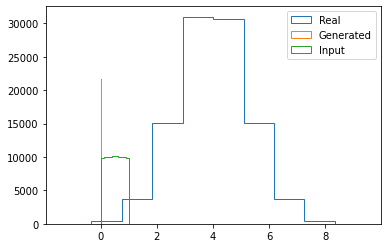

Stage 1 (Epoch: 100)
Mean and Std of Real: (3.9989494291472063, 1.2502287325845125)
Mean and Std of Gen: (0.0001233989, 0.0027711599)


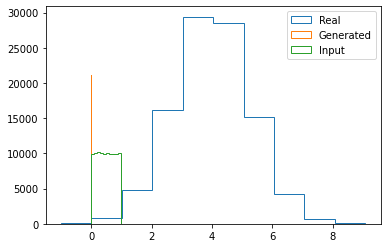

Stage 2 (Epoch: 200)
Mean and Std of Real: (3.999684091822235, 1.2540902468420299)
Mean and Std of Gen: (0.0016074574, 0.0046234773)


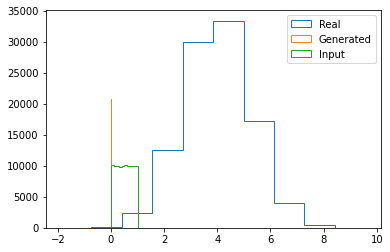

Stage 3 (Epoch: 300)
Mean and Std of Real: (4.006465429575808, 1.2417424648131143)
Mean and Std of Gen: (0.0047818148, 0.009236663)


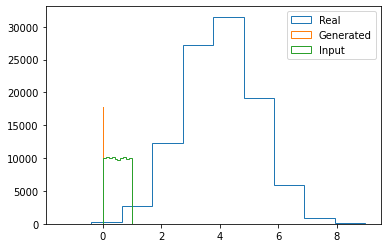

Stage 4 (Epoch: 400)
Mean and Std of Real: (4.00120119214855, 1.2521080782919147)
Mean and Std of Gen: (0.018185144, 0.028120771)


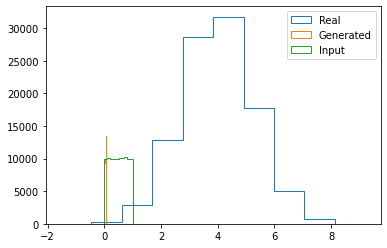

Stage 5 (Epoch: 500)
Mean and Std of Real: (4.007867968939655, 1.2492812400513844)
Mean and Std of Gen: (0.22003421, 0.30287597)


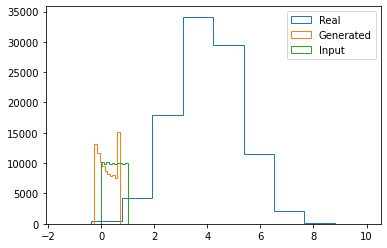

Stage 6 (Epoch: 600)
Mean and Std of Real: (4.002271615108819, 1.245724683842984)
Mean and Std of Gen: (0.8365875, 0.5710077)


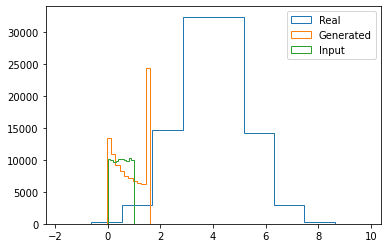

Stage 7 (Epoch: 700)
Mean and Std of Real: (4.001561358439613, 1.2530834593508222)
Mean and Std of Gen: (1.5643698, 0.71446383)


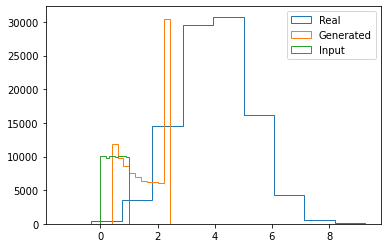

Stage 8 (Epoch: 800)
Mean and Std of Real: (3.9988607041972424, 1.2509609296316178)
Mean and Std of Gen: (2.0082898, 0.9003844)


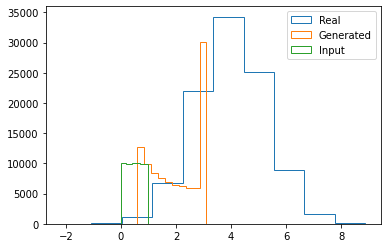

Stage 9 (Epoch: 900)
Mean and Std of Real: (3.9965126971964664, 1.2514821554751807)
Mean and Std of Gen: (2.5717762, 1.0456779)


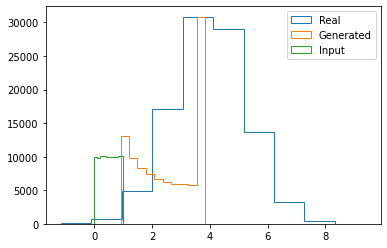

Stage 10 (Epoch: 1000)
Mean and Std of Real: (3.9991407578117855, 1.2534587641556056)
Mean and Std of Gen: (3.4756823, 1.0388023)


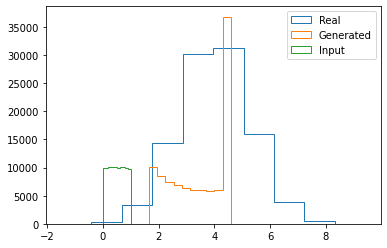

Stage 11 (Epoch: 1100)
Mean and Std of Real: (4.000302341267066, 1.2556022766762658)
Mean and Std of Gen: (3.8810277, 1.2509809)


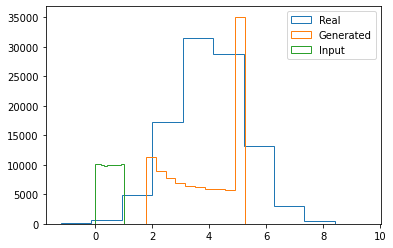

Stage 12 (Epoch: 1200)
Mean and Std of Real: (3.9958001871287974, 1.2431713494695624)
Mean and Std of Gen: (4.38226, 1.3688116)


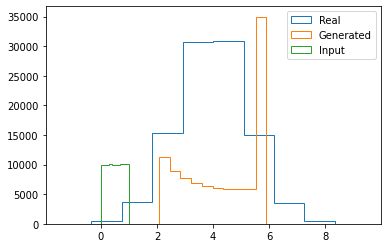

Stage 13 (Epoch: 1300)
Mean and Std of Real: (3.9973498033041386, 1.25180871036819)
Mean and Std of Gen: (5.1239986, 1.2903663)


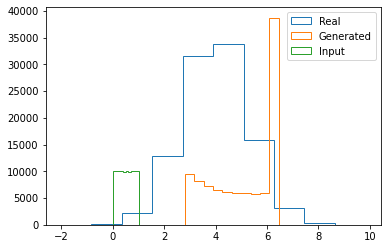

Stage 14 (Epoch: 1400)
Mean and Std of Real: (3.9980563247870213, 1.2479363240347097)
Mean and Std of Gen: (5.5901217, 1.3917568)


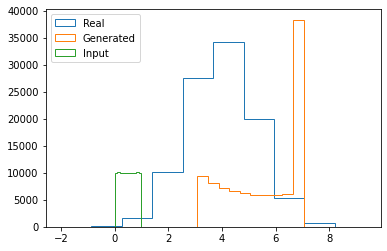

Stage 15 (Epoch: 1500)
Mean and Std of Real: (3.997762128960357, 1.250837065808133)
Mean and Std of Gen: (5.9906487, 1.4589199)


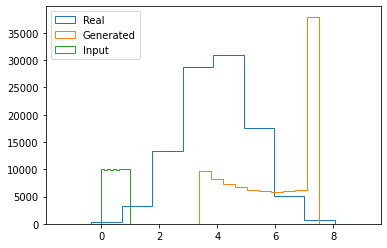

Stage 16 (Epoch: 1600)
Mean and Std of Real: (4.005370244954438, 1.251420285697147)
Mean and Std of Gen: (6.157351, 1.6422819)


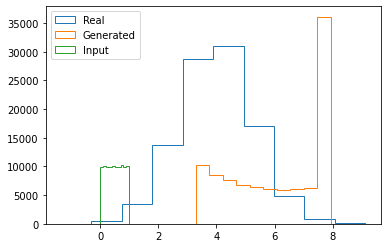

Stage 17 (Epoch: 1700)
Mean and Std of Real: (3.9956784226210433, 1.2498886175936865)
Mean and Std of Gen: (6.49596, 1.651783)


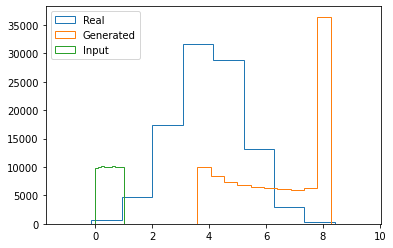

Stage 18 (Epoch: 1800)
Mean and Std of Real: (3.996806244369754, 1.248814039729065)
Mean and Std of Gen: (6.811717, 1.5981234)


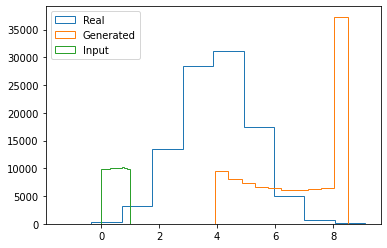

Stage 19 (Epoch: 1900)
Mean and Std of Real: (3.9923539843431373, 1.2480489625694664)
Mean and Std of Gen: (6.892277, 1.6597849)


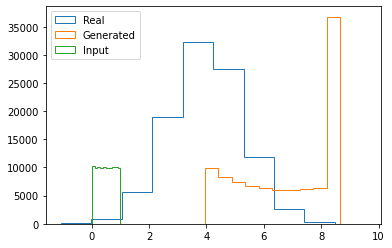

Stage 20 (Epoch: 2000)
Mean and Std of Real: (3.9962074873160427, 1.245387377829232)
Mean and Std of Gen: (6.814111, 1.7646898)


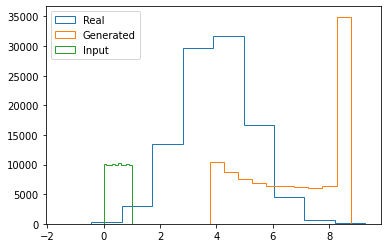

Stage 21 (Epoch: 2100)
Mean and Std of Real: (4.001766168913868, 1.2498423217989418)
Mean and Std of Gen: (6.771366, 1.7084054)


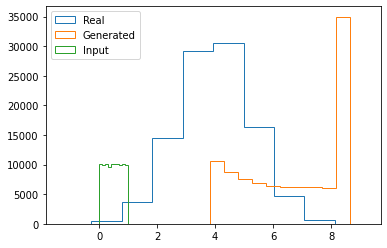

Stage 22 (Epoch: 2200)
Mean and Std of Real: (3.9978561354972055, 1.2527268943469725)
Mean and Std of Gen: (6.7495513, 1.6668364)


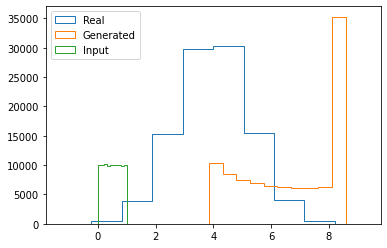

Stage 23 (Epoch: 2300)
Mean and Std of Real: (4.000940601484586, 1.253253819380993)
Mean and Std of Gen: (6.574193, 1.6723288)


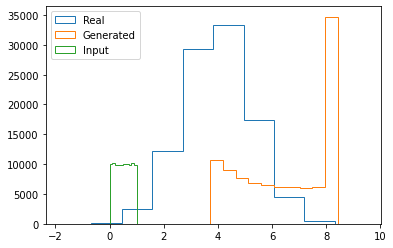

Stage 24 (Epoch: 2400)
Mean and Std of Real: (4.010323612270336, 1.2477386694427)
Mean and Std of Gen: (6.359264, 1.6495823)


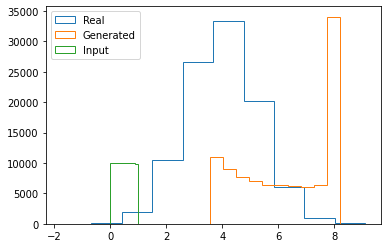

Stage 25 (Epoch: 2500)
Mean and Std of Real: (3.999630205527812, 1.254700595568247)
Mean and Std of Gen: (6.2947893, 1.462528)


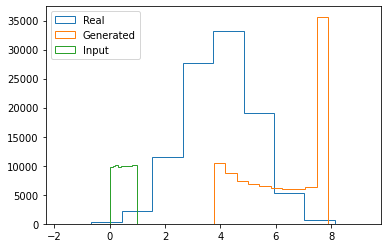

Stage 26 (Epoch: 2600)
Mean and Std of Real: (4.00012294414537, 1.2509482640093832)
Mean and Std of Gen: (5.770676, 1.5511016)


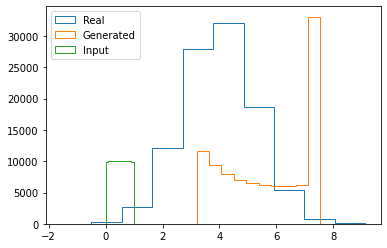

Stage 27 (Epoch: 2700)
Mean and Std of Real: (3.994711387188466, 1.245212980628233)
Mean and Std of Gen: (5.3503976, 1.504406)


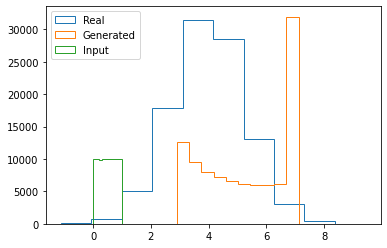

Stage 28 (Epoch: 2800)
Mean and Std of Real: (4.001152201393625, 1.2500968154632135)
Mean and Std of Gen: (5.054095, 1.3580853)


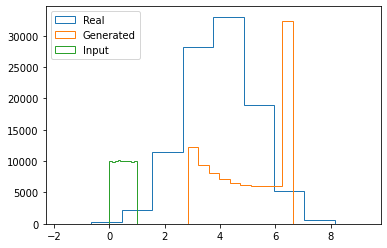

Stage 29 (Epoch: 2900)
Mean and Std of Real: (4.002409875427954, 1.2453783396924005)
Mean and Std of Gen: (4.455734, 1.3889197)


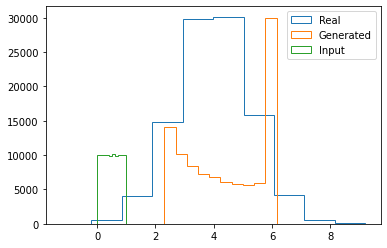

Stage 30 (Epoch: 3000)
Mean and Std of Real: (4.005935946670286, 1.2472769355419748)
Mean and Std of Gen: (4.1602592, 1.2340837)


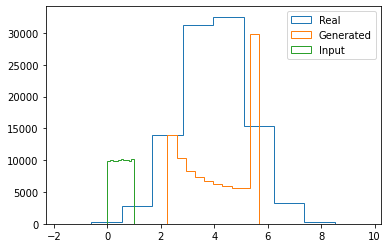

Stage 31 (Epoch: 3100)
Mean and Std of Real: (3.9886394784177512, 1.2485178421920118)
Mean and Std of Gen: (3.7461822, 1.1836314)


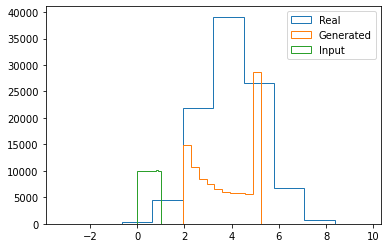

Stage 32 (Epoch: 3200)
Mean and Std of Real: (4.002362794242264, 1.2487074464816517)
Mean and Std of Gen: (3.425939, 1.099193)


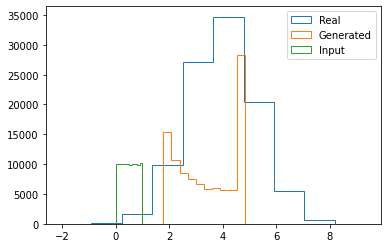

Stage 33 (Epoch: 3300)
Mean and Std of Real: (4.001257992334782, 1.2505490044024559)
Mean and Std of Gen: (3.1722791, 1.0588462)


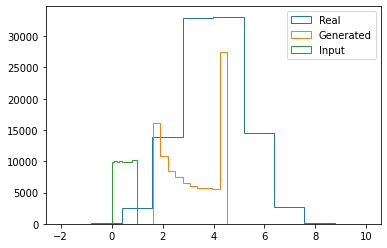

Stage 34 (Epoch: 3400)
Mean and Std of Real: (3.9942267970263794, 1.2511030001191925)
Mean and Std of Gen: (2.94024, 1.0984358)


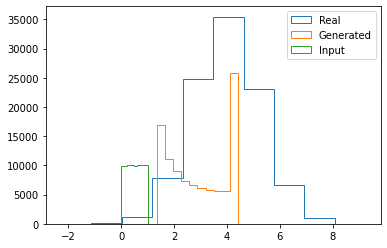

Stage 35 (Epoch: 3500)
Mean and Std of Real: (4.003113257077689, 1.2473678282020695)
Mean and Std of Gen: (3.06491, 1.036499)


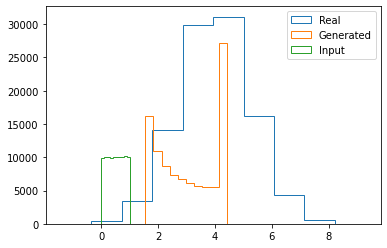

Stage 36 (Epoch: 3600)
Mean and Std of Real: (3.995624712936653, 1.2517470523080798)
Mean and Std of Gen: (3.1259897, 1.1490824)


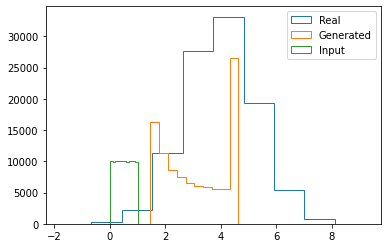

Stage 37 (Epoch: 3700)
Mean and Std of Real: (3.9982534000228718, 1.247253809446407)
Mean and Std of Gen: (3.4157906, 1.1971256)


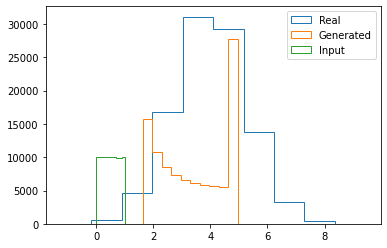

Stage 38 (Epoch: 3800)
Mean and Std of Real: (4.00490061638932, 1.2497716256330107)
Mean and Std of Gen: (3.7824981, 1.1183814)


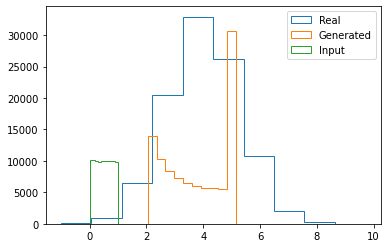

Stage 39 (Epoch: 3900)
Mean and Std of Real: (4.007189563304578, 1.2534539752232179)
Mean and Std of Gen: (3.8115797, 1.1771256)


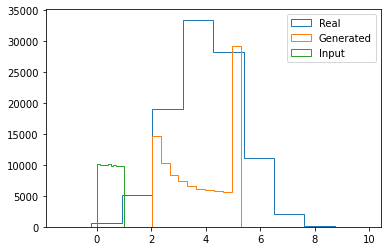

Stage 40 (Epoch: 4000)
Mean and Std of Real: (3.999965641792611, 1.2550532501916465)
Mean and Std of Gen: (3.7982562, 1.287456)


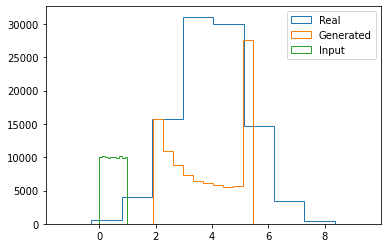

Stage 41 (Epoch: 4100)
Mean and Std of Real: (4.002285352112291, 1.249435749222967)
Mean and Std of Gen: (4.0496035, 1.2340398)


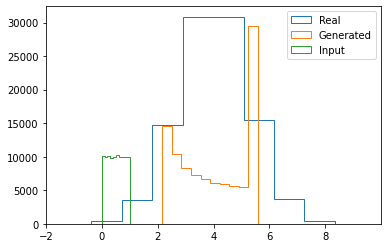

Stage 42 (Epoch: 4200)
Mean and Std of Real: (3.997684625421583, 1.2485809468092124)
Mean and Std of Gen: (4.1913486, 1.2223256)


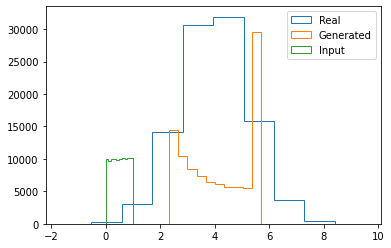

Stage 43 (Epoch: 4300)
Mean and Std of Real: (3.9974653137391614, 1.2475154171992788)
Mean and Std of Gen: (4.2082367, 1.3036174)


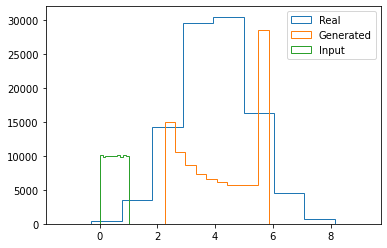

Stage 44 (Epoch: 4400)
Mean and Std of Real: (3.9996012904562934, 1.2532580407725498)
Mean and Std of Gen: (4.215958, 1.3809558)


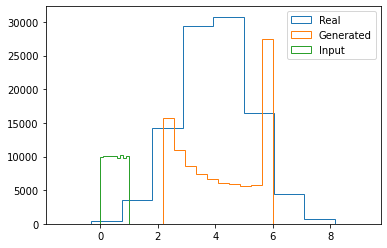

Stage 45 (Epoch: 4500)
Mean and Std of Real: (4.003119850824007, 1.2480164827052862)
Mean and Std of Gen: (4.4993134, 1.254116)


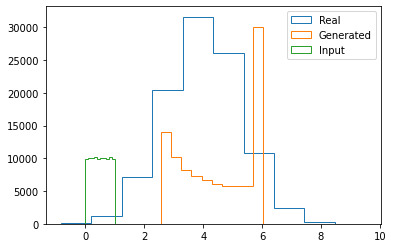

Stage 46 (Epoch: 4600)
Mean and Std of Real: (3.998451688803709, 1.2498788167451789)
Mean and Std of Gen: (4.560433, 1.2574894)


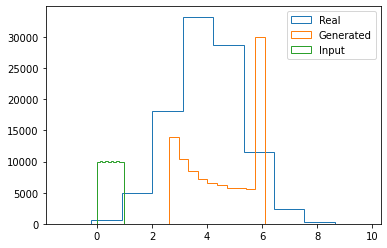

Stage 47 (Epoch: 4700)
Mean and Std of Real: (4.009083763677151, 1.2484620153817227)
Mean and Std of Gen: (4.368556, 1.4006481)


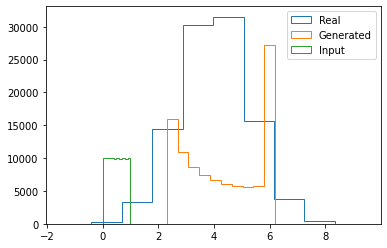

Stage 48 (Epoch: 4800)
Mean and Std of Real: (3.9992235368822997, 1.247153042953097)
Mean and Std of Gen: (4.6040735, 1.2490079)


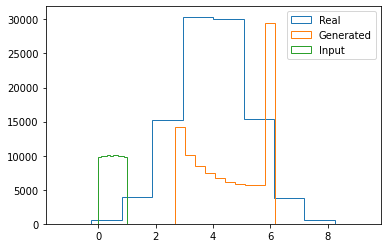

Stage 49 (Epoch: 4900)
Mean and Std of Real: (4.003995926872275, 1.2489743688319175)
Mean and Std of Gen: (4.3318276, 1.3568804)


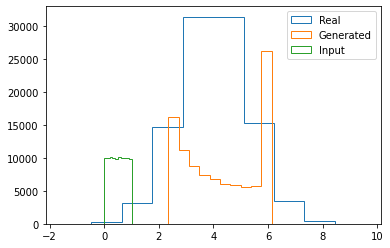

Stage 50 (Epoch: 5000)
Mean and Std of Real: (3.996801481977445, 1.2488395409891762)
Mean and Std of Gen: (4.422008, 1.2490075)


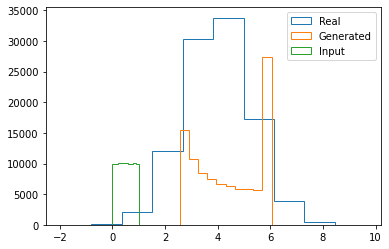

Stage 51 (Epoch: 5100)
Mean and Std of Real: (3.9979539062320804, 1.247025908218531)
Mean and Std of Gen: (4.3852186, 1.2027373)


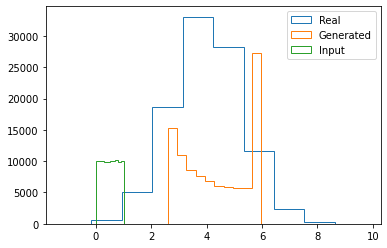

Stage 52 (Epoch: 5200)
Mean and Std of Real: (3.997823121560353, 1.2521158558672971)
Mean and Std of Gen: (4.2097616, 1.1862967)


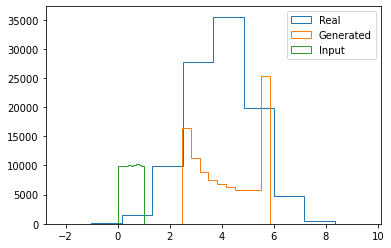

Stage 53 (Epoch: 5300)
Mean and Std of Real: (3.9987353789918654, 1.2460756421981127)
Mean and Std of Gen: (3.9212909, 1.3129251)


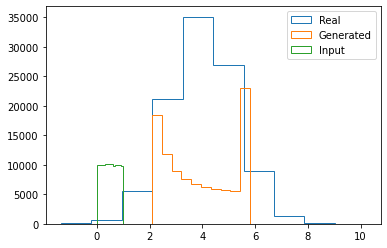

Stage 54 (Epoch: 5400)
Mean and Std of Real: (4.004695196486113, 1.2436055199201088)
Mean and Std of Gen: (3.9915774, 1.2273959)


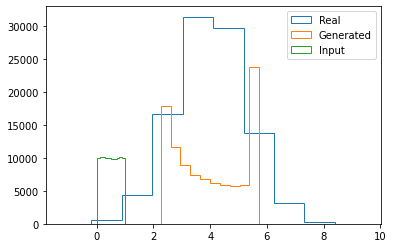

Stage 55 (Epoch: 5500)
Mean and Std of Real: (3.9969203696373317, 1.2481867431206386)
Mean and Std of Gen: (3.989653, 1.1695179)


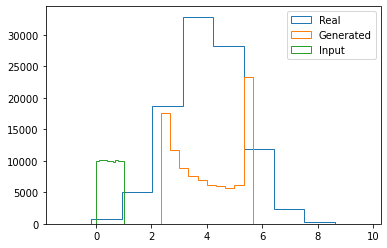

Stage 56 (Epoch: 5600)
Mean and Std of Real: (4.0004510162566325, 1.246947619064037)
Mean and Std of Gen: (3.9380922, 1.1715516)


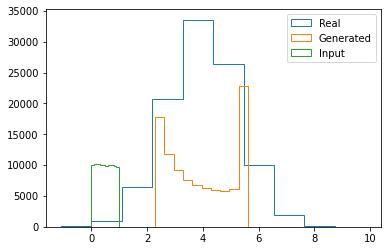

Stage 57 (Epoch: 5700)
Mean and Std of Real: (3.9994182425761733, 1.2521108542137)
Mean and Std of Gen: (3.8463135, 1.2065799)


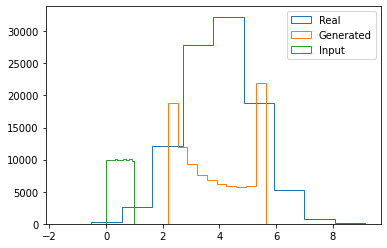

Stage 58 (Epoch: 5800)
Mean and Std of Real: (4.000556370246787, 1.2448220364793998)
Mean and Std of Gen: (3.9325435, 1.1626967)


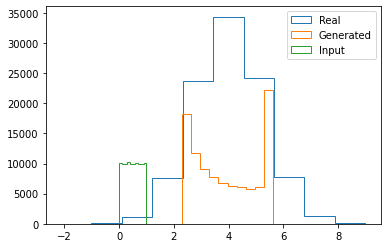

Stage 59 (Epoch: 5900)
Mean and Std of Real: (4.001155643703892, 1.2463200932520395)
Mean and Std of Gen: (3.972049, 1.1525795)


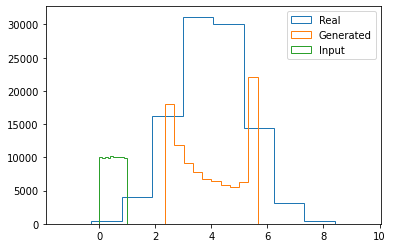

Stage 60 (Epoch: 6000)
Mean and Std of Real: (4.001078457693502, 1.2508364198862592)
Mean and Std of Gen: (3.8571682, 1.2525351)


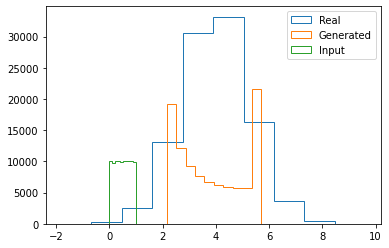

Stage 61 (Epoch: 6100)
Mean and Std of Real: (4.003581663839491, 1.2507734114710403)
Mean and Std of Gen: (4.058345, 1.1154244)


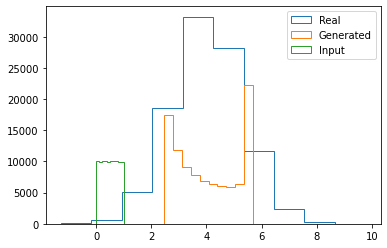

Stage 62 (Epoch: 6200)
Mean and Std of Real: (3.994654702717494, 1.2495084056998742)
Mean and Std of Gen: (3.8287735, 1.2982973)


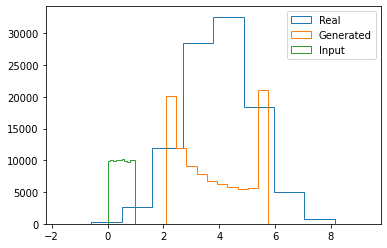

Stage 63 (Epoch: 6300)
Mean and Std of Real: (3.9953457246065907, 1.247987279558519)
Mean and Std of Gen: (3.919098, 1.3008518)


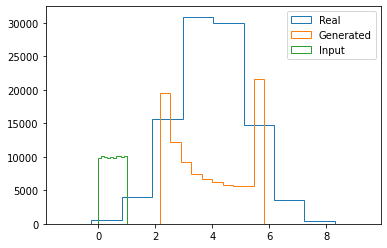

Stage 64 (Epoch: 6400)
Mean and Std of Real: (3.9929504582436492, 1.2486034241589206)
Mean and Std of Gen: (3.997167, 1.3086642)


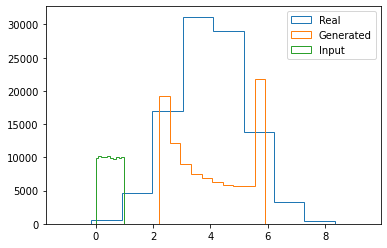

Stage 65 (Epoch: 6500)
Mean and Std of Real: (3.997390279899246, 1.25325568680873)
Mean and Std of Gen: (3.9905493, 1.3280582)


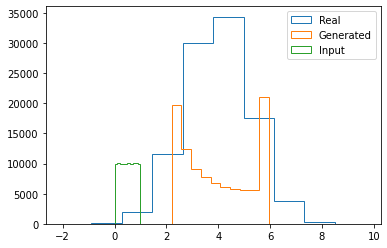

Stage 66 (Epoch: 6600)
Mean and Std of Real: (4.003621747378283, 1.2507283437915113)
Mean and Std of Gen: (4.1957293, 1.193299)


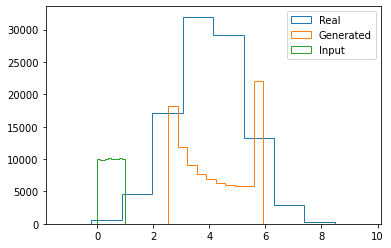

Stage 67 (Epoch: 6700)
Mean and Std of Real: (4.006289103606448, 1.2523037969116504)
Mean and Std of Gen: (3.9940279, 1.3142017)


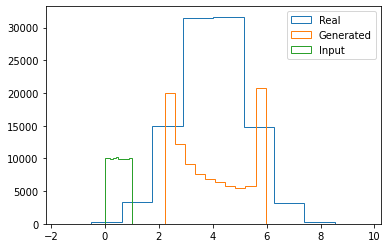

Stage 68 (Epoch: 6800)
Mean and Std of Real: (4.000115389472736, 1.249107816081655)
Mean and Std of Gen: (3.8799913, 1.3428857)


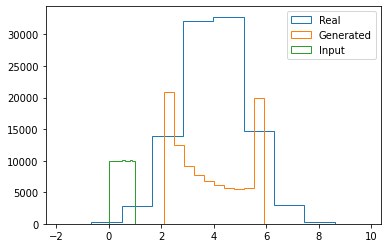

Stage 69 (Epoch: 6900)
Mean and Std of Real: (4.001973006508053, 1.2469255576105216)
Mean and Std of Gen: (4.0683336, 1.2002988)


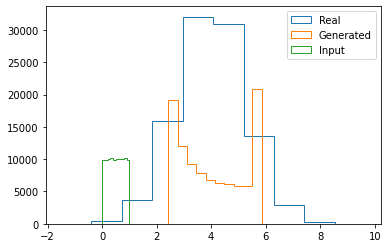

Stage 70 (Epoch: 7000)
Mean and Std of Real: (4.003150580314669, 1.2503090559956844)
Mean and Std of Gen: (3.946673, 1.2614576)


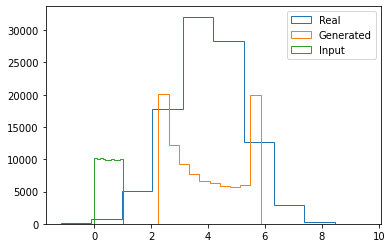

Stage 71 (Epoch: 7100)
Mean and Std of Real: (4.001079828293718, 1.2521478081703246)
Mean and Std of Gen: (3.8986325, 1.27903)


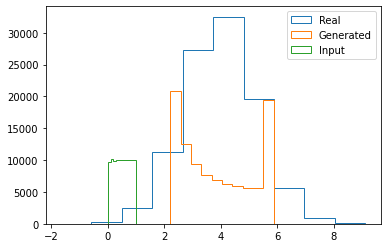

Stage 72 (Epoch: 7200)
Mean and Std of Real: (4.001695256724353, 1.2560197222215108)
Mean and Std of Gen: (4.10589, 1.170773)


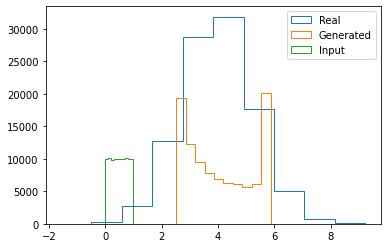

Stage 73 (Epoch: 7300)
Mean and Std of Real: (4.00343678681078, 1.2506451797744598)
Mean and Std of Gen: (4.0679555, 1.2541913)


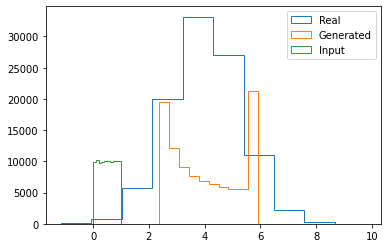

Stage 74 (Epoch: 7400)
Mean and Std of Real: (4.0003914479913245, 1.2499753790100572)
Mean and Std of Gen: (4.1318727, 1.2328775)


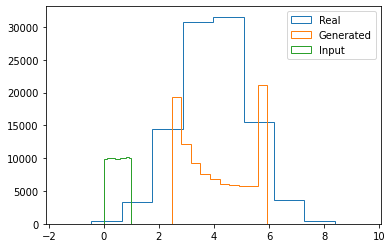

Stage 75 (Epoch: 7500)
Mean and Std of Real: (4.0065770817767, 1.252599474436054)
Mean and Std of Gen: (4.0414777, 1.2538164)


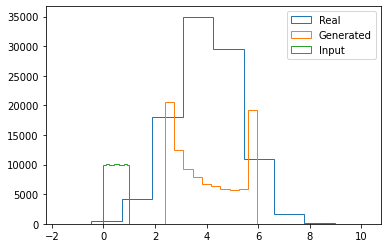

Stage 76 (Epoch: 7600)
Mean and Std of Real: (4.002367741548434, 1.2456267613964447)
Mean and Std of Gen: (4.042218, 1.2812102)


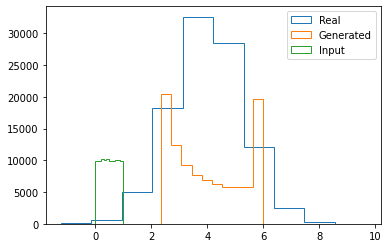

Stage 77 (Epoch: 7700)
Mean and Std of Real: (4.00252033852531, 1.2470597758154012)
Mean and Std of Gen: (3.915843, 1.3362762)


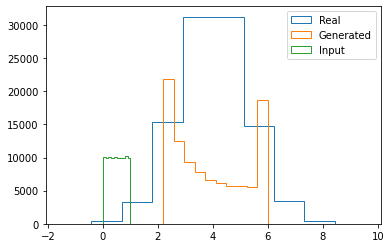

Stage 78 (Epoch: 7800)
Mean and Std of Real: (4.003376872480856, 1.251905845995779)
Mean and Std of Gen: (3.906062, 1.3279251)


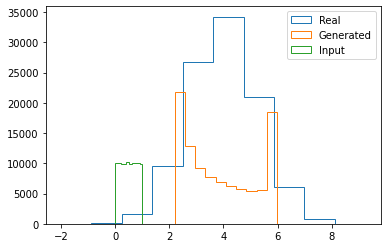

Stage 79 (Epoch: 7900)
Mean and Std of Real: (4.005517249553293, 1.2542264644648384)
Mean and Std of Gen: (3.9921174, 1.2544113)


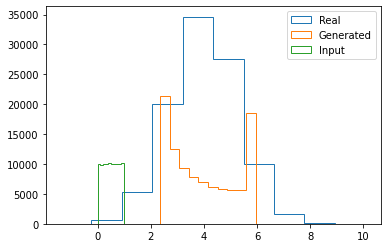

Stage 80 (Epoch: 8000)
Mean and Std of Real: (4.001734899850243, 1.2502425318324586)
Mean and Std of Gen: (3.945514, 1.2794504)


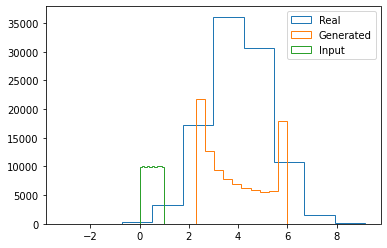

Stage 81 (Epoch: 8100)
Mean and Std of Real: (3.9905264188125513, 1.2479032850389775)
Mean and Std of Gen: (3.9949937, 1.2352409)


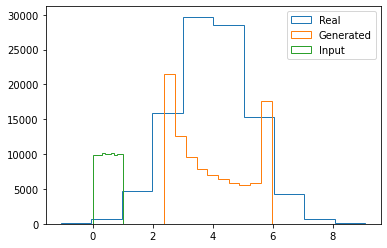

Stage 82 (Epoch: 8200)
Mean and Std of Real: (4.002937868403933, 1.2540471785433551)
Mean and Std of Gen: (3.9503415, 1.2916434)


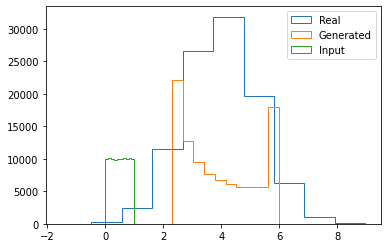

Stage 83 (Epoch: 8300)
Mean and Std of Real: (4.000782849860786, 1.249161868328633)
Mean and Std of Gen: (4.240968, 1.2059827)


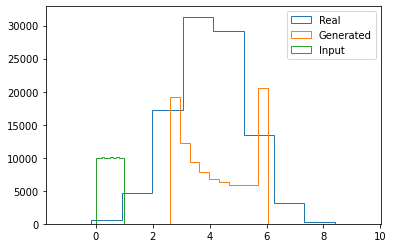

Stage 84 (Epoch: 8400)
Mean and Std of Real: (3.994144575987699, 1.2457213397745217)
Mean and Std of Gen: (4.024218, 1.3388909)


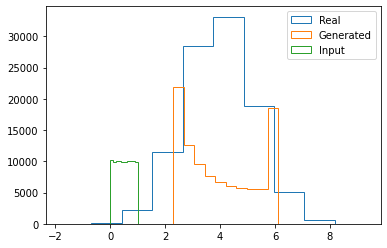

Stage 85 (Epoch: 8500)
Mean and Std of Real: (4.005301693103703, 1.248301918292372)
Mean and Std of Gen: (4.012618, 1.3551527)


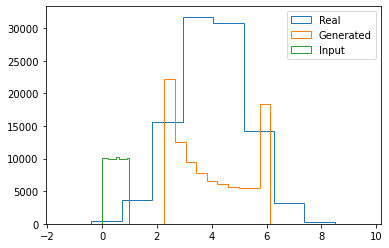

Stage 86 (Epoch: 8600)
Mean and Std of Real: (4.002892135848277, 1.2474136427687186)
Mean and Std of Gen: (4.3854055, 1.1987919)


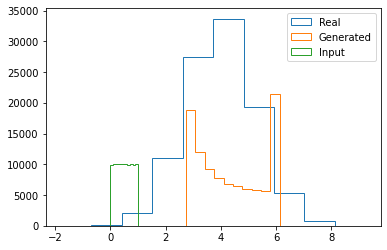

Stage 87 (Epoch: 8700)
Mean and Std of Real: (3.9940649608400394, 1.2507498853528294)
Mean and Std of Gen: (4.4119706, 1.3103994)


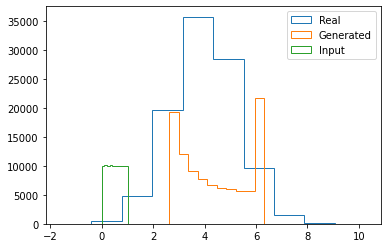

Stage 88 (Epoch: 8800)
Mean and Std of Real: (3.994404249955521, 1.251311422924757)
Mean and Std of Gen: (4.5761547, 1.2729907)


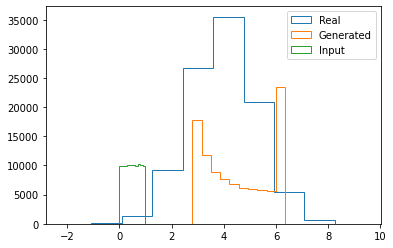

Stage 89 (Epoch: 8900)
Mean and Std of Real: (3.991216098131622, 1.2523771101921242)
Mean and Std of Gen: (4.2349195, 1.211378)


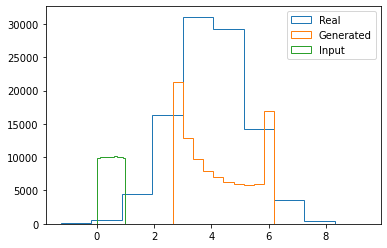

Stage 90 (Epoch: 9000)
Mean and Std of Real: (3.9972378463307647, 1.2519815781341432)
Mean and Std of Gen: (3.998634, 1.217901)


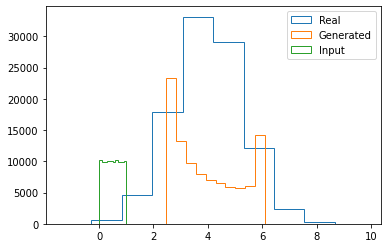

Stage 91 (Epoch: 9100)
Mean and Std of Real: (4.005904523096294, 1.2505312302158487)
Mean and Std of Gen: (4.0132217, 1.2420839)


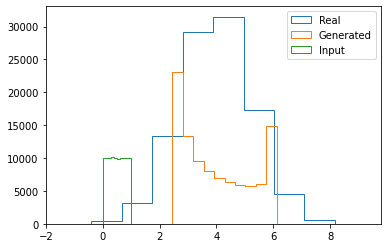

Stage 92 (Epoch: 9200)
Mean and Std of Real: (3.9996802323604497, 1.254893195578264)
Mean and Std of Gen: (4.01624, 1.2601769)


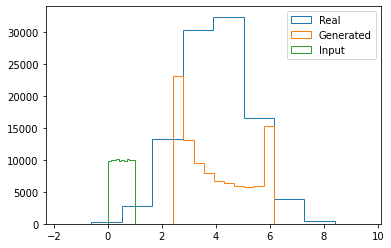

Stage 93 (Epoch: 9300)
Mean and Std of Real: (3.9976198932748965, 1.2499029297536564)
Mean and Std of Gen: (4.0149565, 1.2495127)


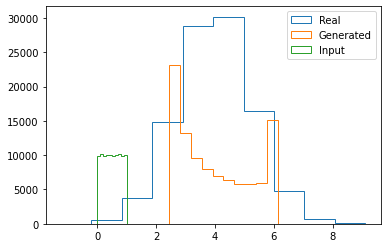

Stage 94 (Epoch: 9400)
Mean and Std of Real: (3.9842996165360103, 1.2512119234538124)
Mean and Std of Gen: (4.003766, 1.2494732)


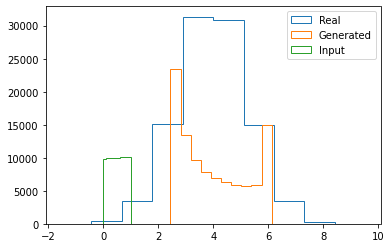

Stage 95 (Epoch: 9500)
Mean and Std of Real: (4.00439978497317, 1.2526460349041293)
Mean and Std of Gen: (4.010489, 1.252511)


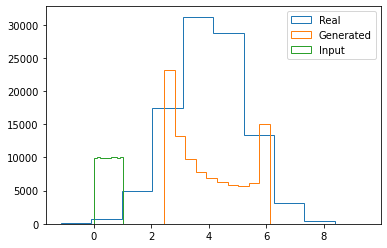

Stage 96 (Epoch: 9600)
Mean and Std of Real: (4.007226888081271, 1.2496072724928964)
Mean and Std of Gen: (4.0136685, 1.2481501)


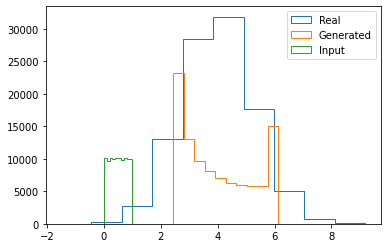

Stage 97 (Epoch: 9700)
Mean and Std of Real: (4.004503965073022, 1.2486872928424453)
Mean and Std of Gen: (4.014185, 1.2311523)


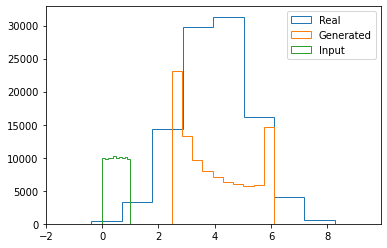

Stage 98 (Epoch: 9800)
Mean and Std of Real: (3.9985453265518993, 1.2498591602997247)
Mean and Std of Gen: (4.164131, 1.1536398)


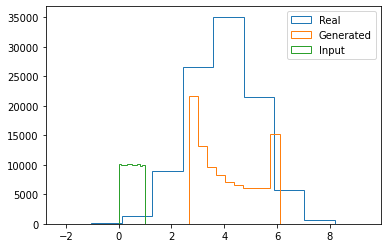

Stage 99 (Epoch: 9900)
Mean and Std of Real: (3.996316676959895, 1.2461514861779917)
Mean and Std of Gen: (4.1538153, 1.1546595)


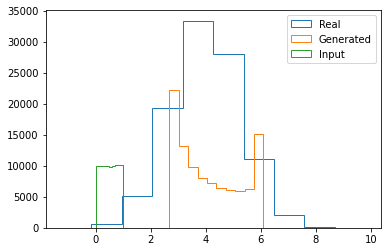

Stage 100 (Epoch: 10000)
Mean and Std of Real: (3.993534366204869, 1.2509232662058978)
Mean and Std of Gen: (4.1534886, 1.1527561)


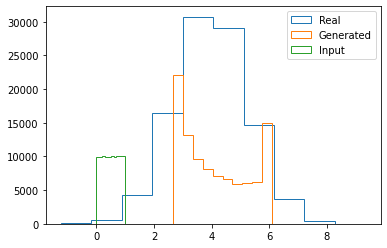

Stage 101 (Epoch: 10100)
Mean and Std of Real: (4.003460610429519, 1.249897367623157)
Mean and Std of Gen: (4.161249, 1.1549567)


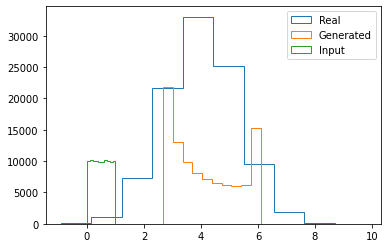

Stage 102 (Epoch: 10200)
Mean and Std of Real: (3.99999175483431, 1.251996967890079)
Mean and Std of Gen: (4.1555367, 1.1532296)


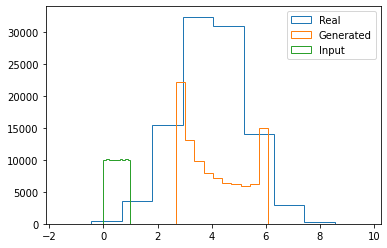

Stage 103 (Epoch: 10300)
Mean and Std of Real: (4.0014866357075976, 1.2488508468896953)
Mean and Std of Gen: (4.1602015, 1.1520313)


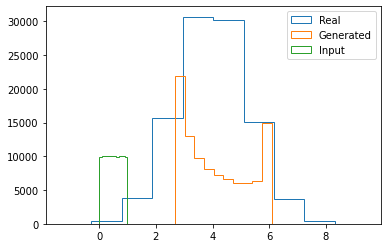

Stage 104 (Epoch: 10400)
Mean and Std of Real: (3.9944797950735205, 1.2477725531378634)
Mean and Std of Gen: (4.163032, 1.1528586)


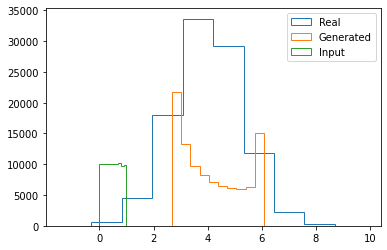

Stage 105 (Epoch: 10500)
Mean and Std of Real: (4.00032576784684, 1.2527551590358803)
Mean and Std of Gen: (4.152336, 1.1531848)


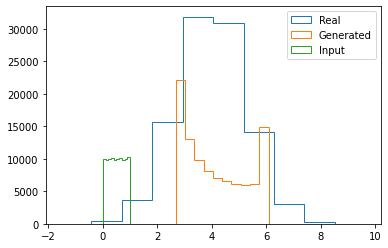

Stage 106 (Epoch: 10600)
Mean and Std of Real: (4.001026245438834, 1.252981795791551)
Mean and Std of Gen: (4.1616874, 1.1568316)


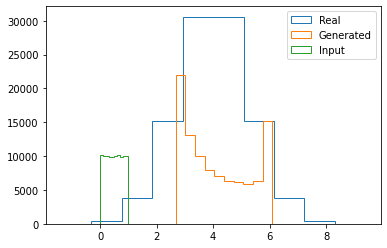

Stage 107 (Epoch: 10700)
Mean and Std of Real: (3.9981259230857384, 1.250842158415071)
Mean and Std of Gen: (4.1628175, 1.1559975)


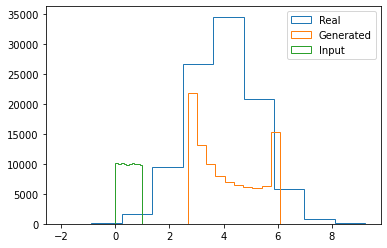

Stage 108 (Epoch: 10800)
Mean and Std of Real: (3.999635281323997, 1.2496577212905589)
Mean and Std of Gen: (4.154385, 1.1554044)


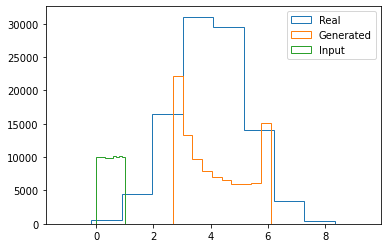

Stage 109 (Epoch: 10900)
Mean and Std of Real: (3.996149783964597, 1.2488813518480717)
Mean and Std of Gen: (4.160744, 1.1535859)


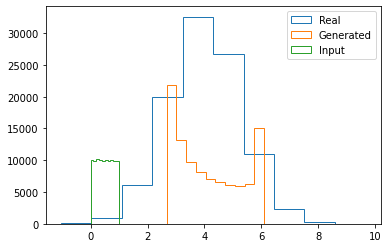

Stage 110 (Epoch: 11000)
Mean and Std of Real: (3.9996723689469196, 1.2504725964136534)
Mean and Std of Gen: (4.1554112, 1.1536037)


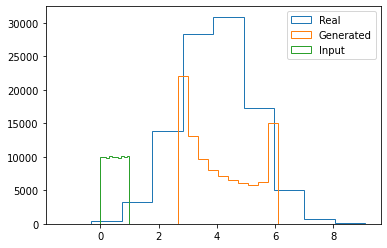

Stage 111 (Epoch: 11100)
Mean and Std of Real: (4.006736933835392, 1.2525214318874434)
Mean and Std of Gen: (4.159373, 1.153679)


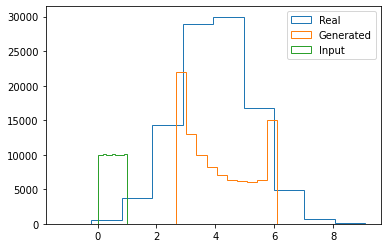

Stage 112 (Epoch: 11200)
Mean and Std of Real: (4.009876223714578, 1.2478234174812197)
Mean and Std of Gen: (4.157395, 1.1522623)


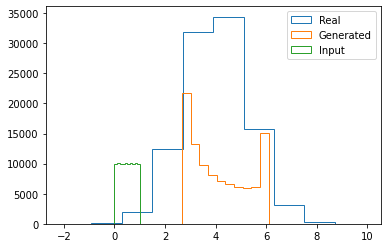

Stage 113 (Epoch: 11300)
Mean and Std of Real: (4.002765481124251, 1.2486535874866025)
Mean and Std of Gen: (4.161993, 1.1534199)


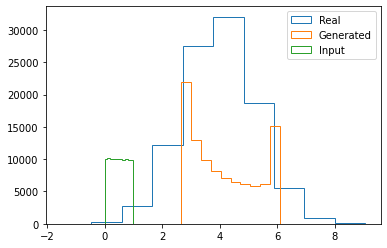

Stage 114 (Epoch: 11400)
Mean and Std of Real: (3.9957544489556285, 1.2522725561534775)
Mean and Std of Gen: (4.160234, 1.154252)


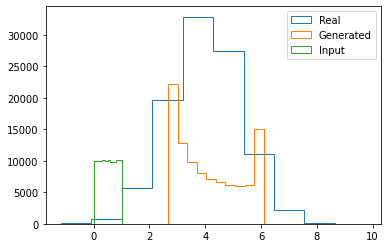

Stage 115 (Epoch: 11500)
Mean and Std of Real: (3.9983695705476014, 1.2486394801035239)
Mean and Std of Gen: (4.1589375, 1.1521022)


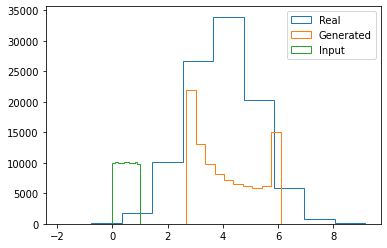

Stage 116 (Epoch: 11600)
Mean and Std of Real: (4.002483698825946, 1.2485256685382247)
Mean and Std of Gen: (4.1623616, 1.155706)


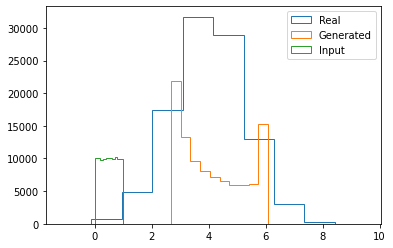

Stage 117 (Epoch: 11700)
Mean and Std of Real: (3.994782990040089, 1.2495173978308465)
Mean and Std of Gen: (4.164289, 1.153263)


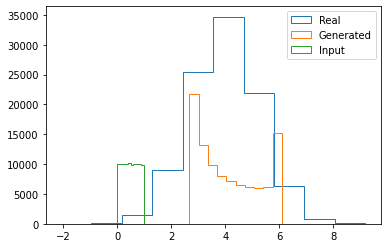

Stage 118 (Epoch: 11800)
Mean and Std of Real: (3.9966110543304136, 1.2470245063775045)
Mean and Std of Gen: (4.161593, 1.1536435)


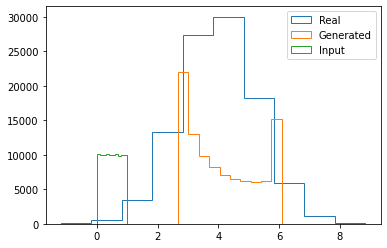

Stage 119 (Epoch: 11900)
Mean and Std of Real: (3.994671157391811, 1.2512632216698172)
Mean and Std of Gen: (4.1622643, 1.1565775)


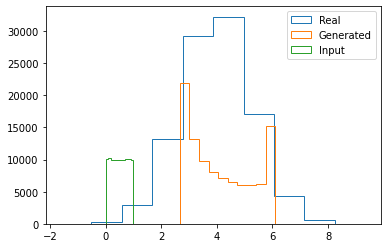

Stage 120 (Epoch: 12000)
Mean and Std of Real: (3.994232045426067, 1.247000849387953)
Mean and Std of Gen: (4.1555834, 1.1520438)


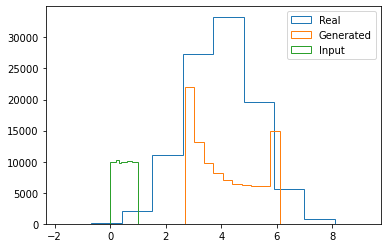

Stage 121 (Epoch: 12100)
Mean and Std of Real: (4.001120295050624, 1.2480429990034172)
Mean and Std of Gen: (4.154031, 1.1529286)


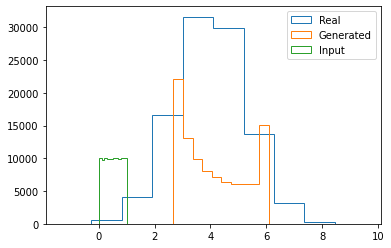

Stage 122 (Epoch: 12200)
Mean and Std of Real: (3.9997641110484667, 1.2502215162640151)
Mean and Std of Gen: (4.1653457, 1.1530603)


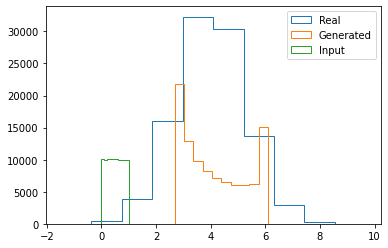

Stage 123 (Epoch: 12300)
Mean and Std of Real: (3.9995582254062705, 1.246877741386561)
Mean and Std of Gen: (4.1597104, 1.1530079)


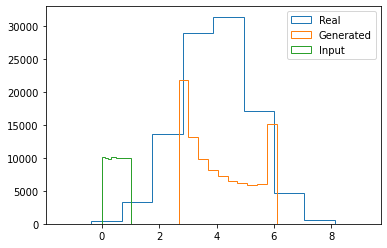

Stage 124 (Epoch: 12400)
Mean and Std of Real: (3.999836253567639, 1.2493733569744911)
Mean and Std of Gen: (4.158465, 1.1541708)


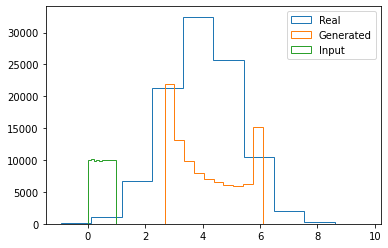

Stage 125 (Epoch: 12500)
Mean and Std of Real: (4.001882244241204, 1.2471311204542754)
Mean and Std of Gen: (4.1574173, 1.1506927)


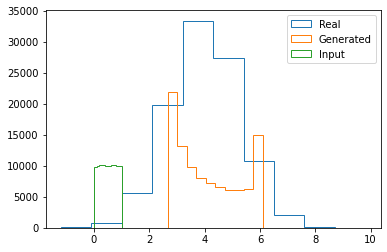

Stage 126 (Epoch: 12600)
Mean and Std of Real: (3.9961008815306305, 1.2460899848265907)
Mean and Std of Gen: (4.156161, 1.1524956)


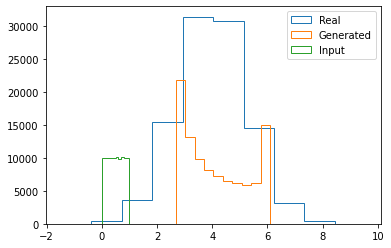

Stage 127 (Epoch: 12700)
Mean and Std of Real: (3.996381540590148, 1.2480187125213842)
Mean and Std of Gen: (4.155116, 1.1533417)


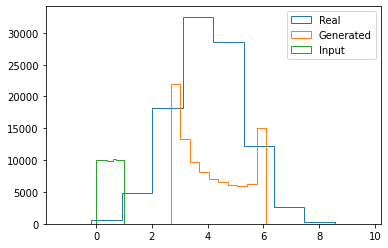

Stage 128 (Epoch: 12800)
Mean and Std of Real: (3.996979983007235, 1.2545984194263515)
Mean and Std of Gen: (4.153784, 1.1520734)


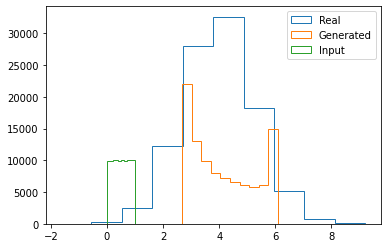

Stage 129 (Epoch: 12900)
Mean and Std of Real: (4.00616832986055, 1.2498692882312286)
Mean and Std of Gen: (4.1622624, 1.1539335)


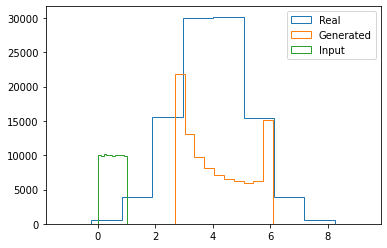

Stage 130 (Epoch: 13000)
Mean and Std of Real: (4.000383477129814, 1.2518327505927176)
Mean and Std of Gen: (4.159969, 1.1532847)


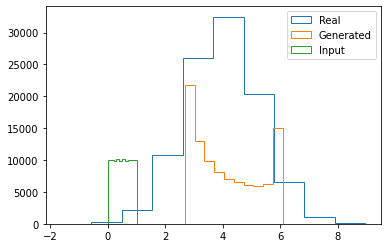

Stage 131 (Epoch: 13100)
Mean and Std of Real: (4.002093378664564, 1.2515217634192395)
Mean and Std of Gen: (4.16566, 1.1549641)


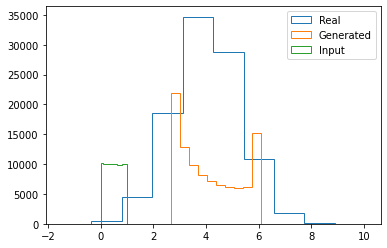

Stage 132 (Epoch: 13200)
Mean and Std of Real: (4.005757487402164, 1.248287358428476)
Mean and Std of Gen: (4.157315, 1.1552433)


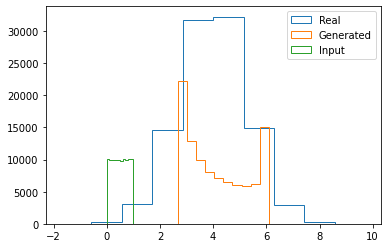

Stage 133 (Epoch: 13300)
Mean and Std of Real: (4.01187984922766, 1.2539108306660893)
Mean and Std of Gen: (4.1628885, 1.1571889)


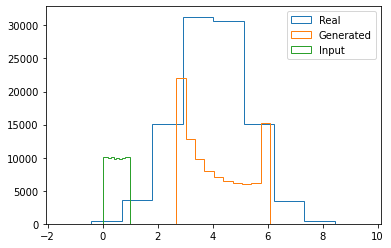

Stage 134 (Epoch: 13400)
Mean and Std of Real: (3.997464224384342, 1.251580162755865)
Mean and Std of Gen: (4.1553745, 1.1559998)


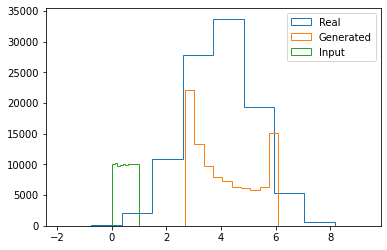

Stage 135 (Epoch: 13500)
Mean and Std of Real: (4.001942581091078, 1.2553178958078295)
Mean and Std of Gen: (4.155801, 1.1542305)


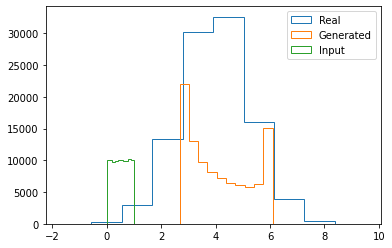

Stage 136 (Epoch: 13600)
Mean and Std of Real: (4.0007811273037275, 1.249993464477938)
Mean and Std of Gen: (4.15404, 1.1532717)


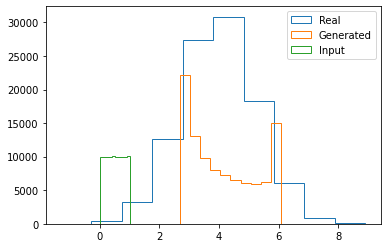

Stage 137 (Epoch: 13700)
Mean and Std of Real: (3.9999763156834187, 1.2496119642689183)
Mean and Std of Gen: (4.1557965, 1.1528728)


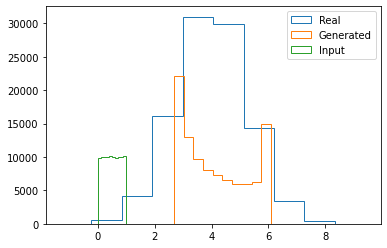

Stage 138 (Epoch: 13800)
Mean and Std of Real: (4.002998848742421, 1.2510762660121248)
Mean and Std of Gen: (4.1631083, 1.1537223)


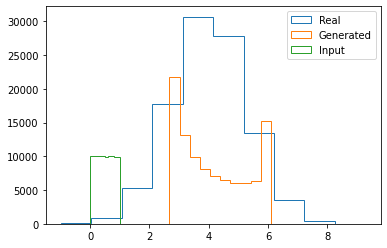

Stage 139 (Epoch: 13900)
Mean and Std of Real: (4.005616688857992, 1.2470847684941446)
Mean and Std of Gen: (4.1582365, 1.1526762)


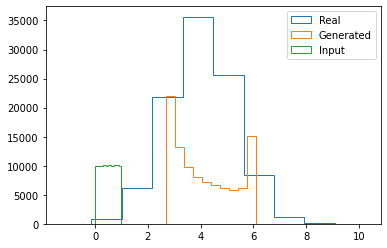

Stage 140 (Epoch: 14000)
Mean and Std of Real: (4.003239511330151, 1.2475625239965296)
Mean and Std of Gen: (4.1522307, 1.1517189)


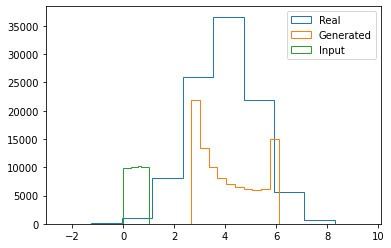

Stage 141 (Epoch: 14100)
Mean and Std of Real: (4.005854475589918, 1.2480604786809444)
Mean and Std of Gen: (4.162774, 1.1571052)


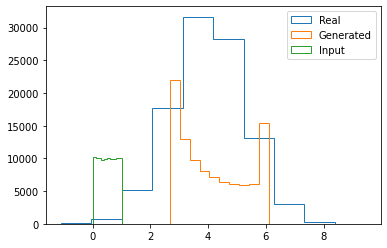

Stage 142 (Epoch: 14200)
Mean and Std of Real: (3.997604786276503, 1.2511550336994015)
Mean and Std of Gen: (4.15561, 1.1562854)


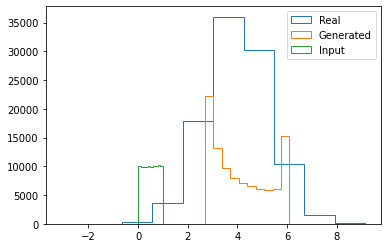

Stage 143 (Epoch: 14300)
Mean and Std of Real: (4.0001813638046695, 1.2472808417508718)
Mean and Std of Gen: (4.1624804, 1.1554873)


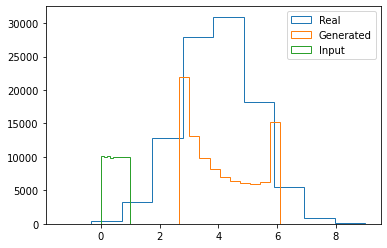

Stage 144 (Epoch: 14400)
Mean and Std of Real: (3.9983544859157667, 1.2514570159831027)
Mean and Std of Gen: (4.1581354, 1.1555793)


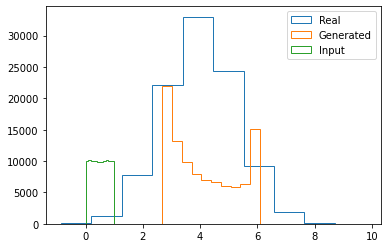

Stage 145 (Epoch: 14500)
Mean and Std of Real: (3.9984823137511616, 1.247957337429573)
Mean and Std of Gen: (4.156273, 1.1552668)


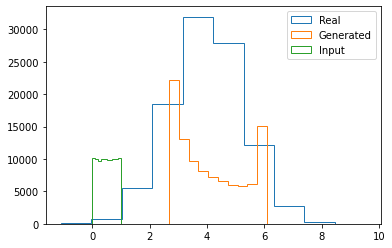

Stage 146 (Epoch: 14600)
Mean and Std of Real: (3.997438886942815, 1.2492289679406632)
Mean and Std of Gen: (4.1605687, 1.1559986)


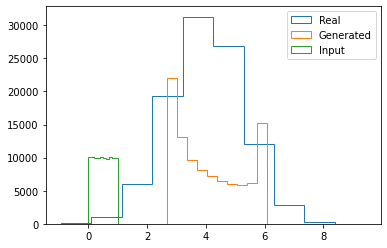

Stage 147 (Epoch: 14700)
Mean and Std of Real: (3.9989472118731437, 1.247438691583113)
Mean and Std of Gen: (4.153695, 1.1529981)


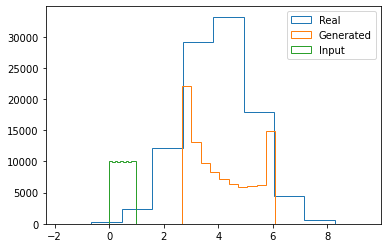

Stage 148 (Epoch: 14800)
Mean and Std of Real: (4.004244521803233, 1.2469809658208224)
Mean and Std of Gen: (4.16513, 1.1547114)


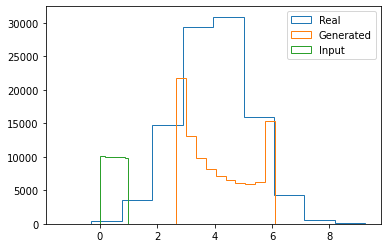

Stage 149 (Epoch: 14900)
Mean and Std of Real: (3.9987685602316905, 1.24818708481572)
Mean and Std of Gen: (4.1605954, 1.1533575)


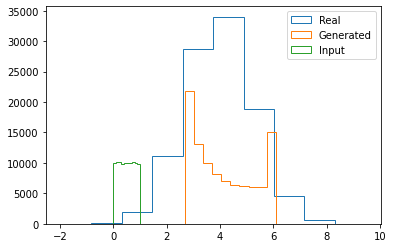

Stage 150 (Epoch: 15000)
Mean and Std of Real: (3.991602886184331, 1.2475331679784207)
Mean and Std of Gen: (4.156338, 1.1527194)


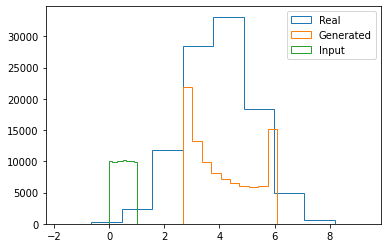

Stage 151 (Epoch: 15100)
Mean and Std of Real: (4.000833004246068, 1.2529017291275404)
Mean and Std of Gen: (4.154605, 1.1540471)


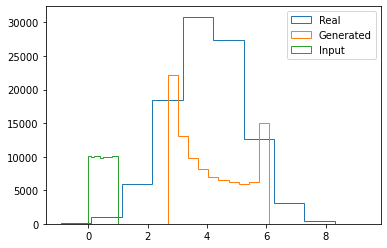

Stage 152 (Epoch: 15200)
Mean and Std of Real: (4.004128671760308, 1.255621019718709)
Mean and Std of Gen: (4.1589384, 1.1550989)


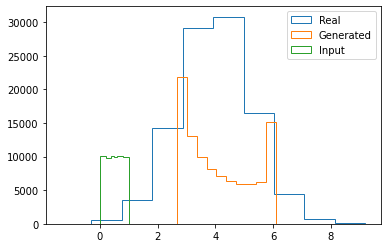

Stage 153 (Epoch: 15300)
Mean and Std of Real: (4.007971279557052, 1.2510598706553127)
Mean and Std of Gen: (4.1595902, 1.154973)


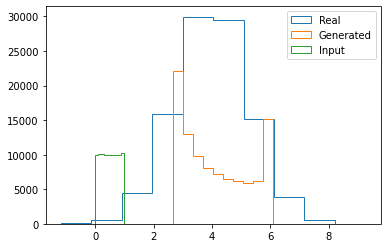

Stage 154 (Epoch: 15400)
Mean and Std of Real: (4.00204895859831, 1.248639226960698)
Mean and Std of Gen: (4.1530004, 1.1526086)


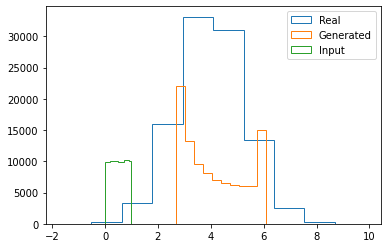

Stage 155 (Epoch: 15500)
Mean and Std of Real: (3.9983853924777097, 1.2478472661761428)
Mean and Std of Gen: (4.1575065, 1.1541132)


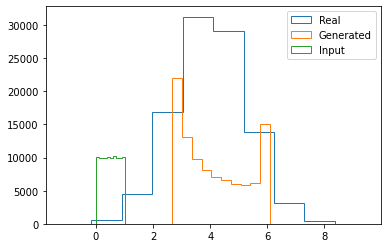

Stage 156 (Epoch: 15600)
Mean and Std of Real: (4.002076755642109, 1.2509291937914915)
Mean and Std of Gen: (4.152271, 1.1529567)


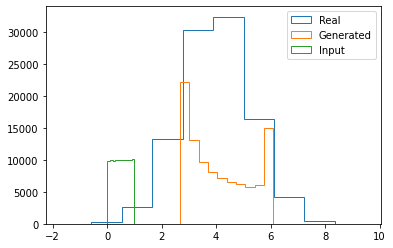

Stage 157 (Epoch: 15700)
Mean and Std of Real: (4.0014183368613105, 1.2458133798707818)
Mean and Std of Gen: (4.156585, 1.1530417)


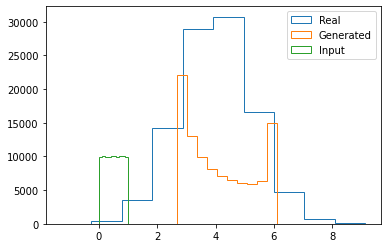

Stage 158 (Epoch: 15800)
Mean and Std of Real: (3.9999764655940075, 1.248609644093465)
Mean and Std of Gen: (4.1610746, 1.1532314)


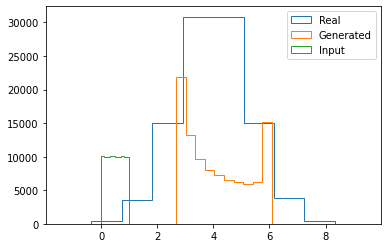

Stage 159 (Epoch: 15900)
Mean and Std of Real: (4.0057614804906505, 1.248330108372639)
Mean and Std of Gen: (4.1624866, 1.1516387)


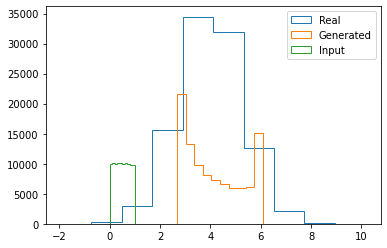

Stage 160 (Epoch: 16000)
Mean and Std of Real: (3.9970568181290473, 1.2485230355087373)
Mean and Std of Gen: (4.1600904, 1.1540765)


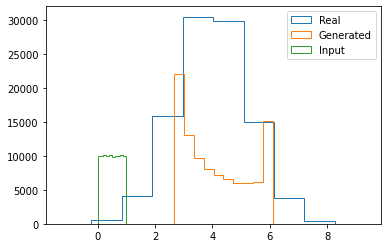

Stage 161 (Epoch: 16100)
Mean and Std of Real: (4.001261810585156, 1.252251386609355)
Mean and Std of Gen: (4.1542354, 1.154859)


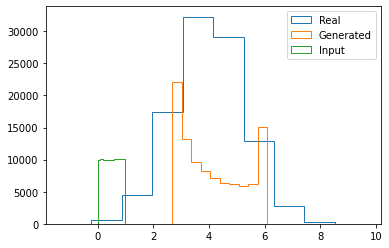

Stage 162 (Epoch: 16200)
Mean and Std of Real: (3.992467415523481, 1.2494251638234397)
Mean and Std of Gen: (4.1526346, 1.1530172)


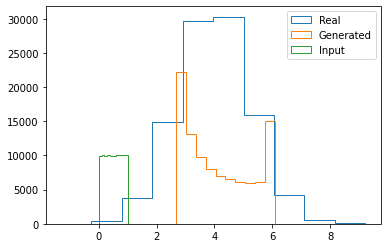

Stage 163 (Epoch: 16300)
Mean and Std of Real: (3.9974564519488185, 1.2473063629792722)
Mean and Std of Gen: (4.162212, 1.1532465)


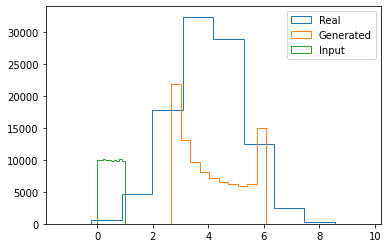

Stage 164 (Epoch: 16400)
Mean and Std of Real: (4.004397074191306, 1.2483749647444113)
Mean and Std of Gen: (4.1542215, 1.1518565)


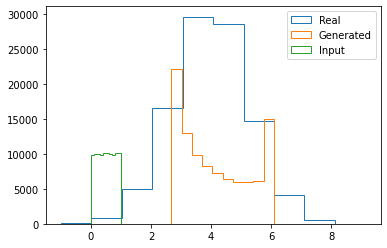

Stage 165 (Epoch: 16500)
Mean and Std of Real: (3.9981734790999686, 1.2483081540740253)
Mean and Std of Gen: (4.1600904, 1.1543722)


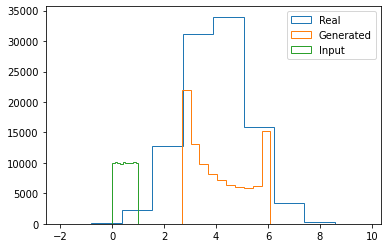

Stage 166 (Epoch: 16600)
Mean and Std of Real: (4.011117059519138, 1.2542478433993072)
Mean and Std of Gen: (4.161284, 1.1530049)


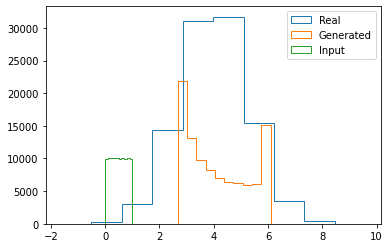

Stage 167 (Epoch: 16700)
Mean and Std of Real: (4.008728257515739, 1.2465423499115444)
Mean and Std of Gen: (4.1540437, 1.1520814)


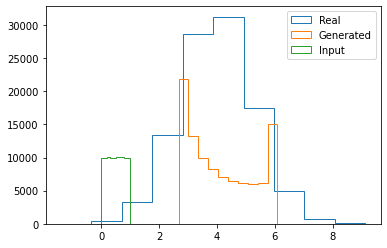

Stage 168 (Epoch: 16800)
Mean and Std of Real: (3.995332760560996, 1.2490894707068092)
Mean and Std of Gen: (4.1606092, 1.1549084)


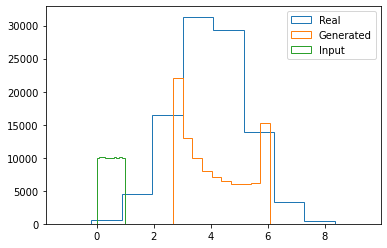

Stage 169 (Epoch: 16900)
Mean and Std of Real: (3.9968615724682524, 1.2507215490402164)
Mean and Std of Gen: (4.1573486, 1.1559986)


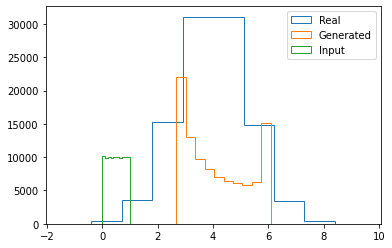

Stage 170 (Epoch: 17000)
Mean and Std of Real: (4.004936389309456, 1.250086005819525)
Mean and Std of Gen: (4.1568093, 1.151253)


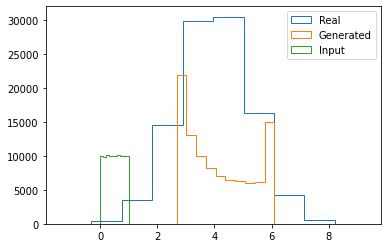

Stage 171 (Epoch: 17100)
Mean and Std of Real: (4.001085179510681, 1.2498869912040527)
Mean and Std of Gen: (4.165314, 1.1561185)


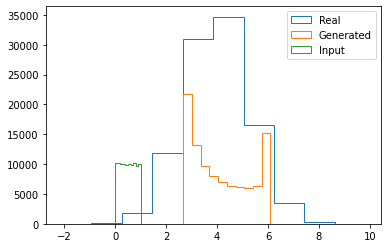

Stage 172 (Epoch: 17200)
Mean and Std of Real: (4.003380159536812, 1.2464410373434547)
Mean and Std of Gen: (4.158605, 1.1538417)


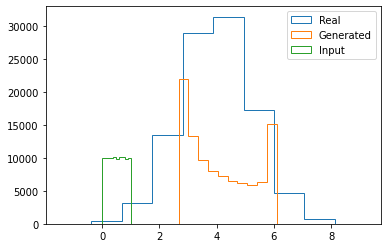

Stage 173 (Epoch: 17300)
Mean and Std of Real: (4.000172808619932, 1.2525042621363176)
Mean and Std of Gen: (4.1559563, 1.1531694)


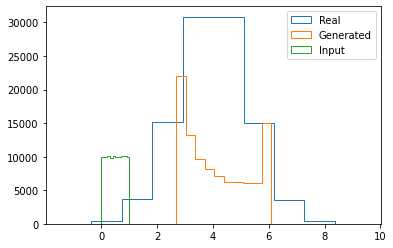

Stage 174 (Epoch: 17400)
Mean and Std of Real: (4.006885438104446, 1.253584272330219)
Mean and Std of Gen: (4.1612015, 1.1552762)


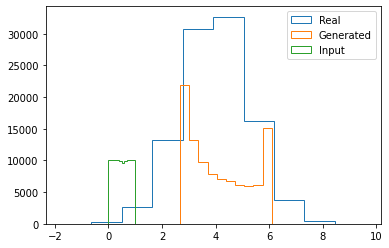

Stage 175 (Epoch: 17500)
Mean and Std of Real: (3.999539152627826, 1.2541184834261159)
Mean and Std of Gen: (4.1515183, 1.1516318)


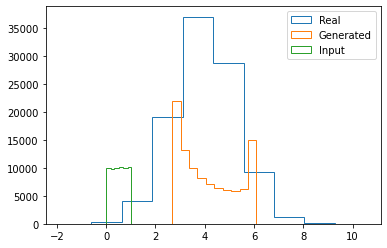

Stage 176 (Epoch: 17600)
Mean and Std of Real: (4.000289680729032, 1.2529934994470382)
Mean and Std of Gen: (4.158826, 1.1524547)


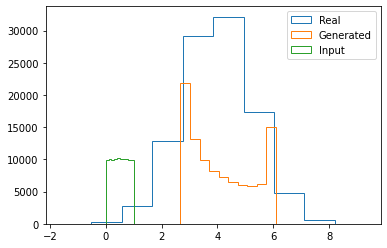

Stage 177 (Epoch: 17700)
Mean and Std of Real: (4.008244279723393, 1.2512310364146784)
Mean and Std of Gen: (4.1547008, 1.1538317)


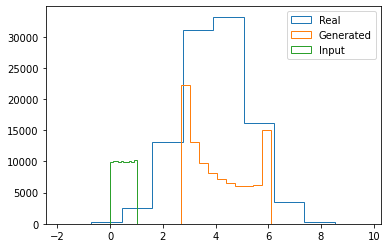

Stage 178 (Epoch: 17800)
Mean and Std of Real: (4.0032383937889255, 1.24885360920837)
Mean and Std of Gen: (4.1625643, 1.1527137)


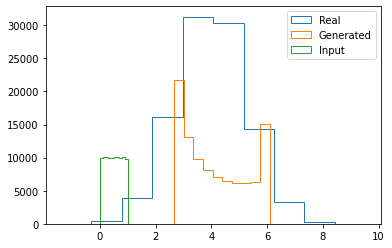

Stage 179 (Epoch: 17900)
Mean and Std of Real: (4.001137590588262, 1.2473702268601659)
Mean and Std of Gen: (4.11693, 1.3291626)


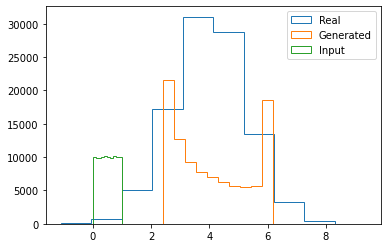

Stage 180 (Epoch: 18000)
Mean and Std of Real: (4.005326303614294, 1.2499486598272231)
Mean and Std of Gen: (4.1274834, 1.3309215)


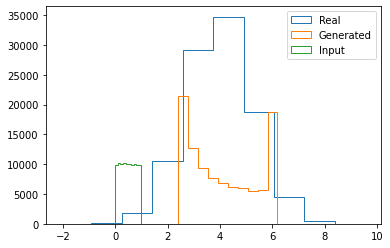

Stage 181 (Epoch: 18100)
Mean and Std of Real: (3.9999054852869556, 1.2529264935111966)
Mean and Std of Gen: (4.121036, 1.3328905)


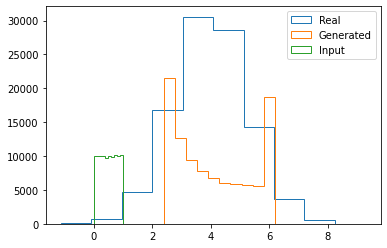

Stage 182 (Epoch: 18200)
Mean and Std of Real: (4.004084476490572, 1.2539864759680828)
Mean and Std of Gen: (4.117586, 1.3306851)


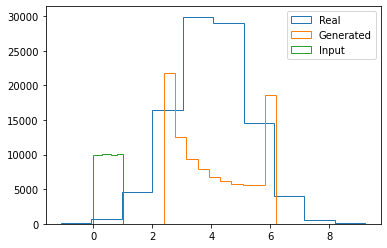

Stage 183 (Epoch: 18300)
Mean and Std of Real: (3.991520017680182, 1.2511004365682885)
Mean and Std of Gen: (4.1202087, 1.332374)


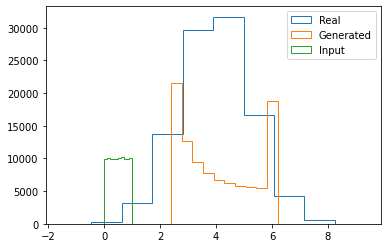

Stage 184 (Epoch: 18400)
Mean and Std of Real: (3.997669617834767, 1.2521637380354487)
Mean and Std of Gen: (4.120148, 1.3272848)


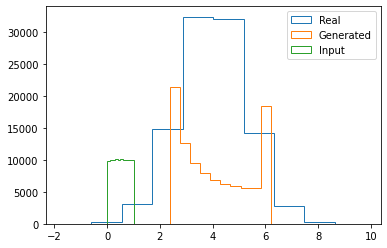

Stage 185 (Epoch: 18500)
Mean and Std of Real: (4.001060110979659, 1.2529959859329123)
Mean and Std of Gen: (4.1226687, 1.3337458)


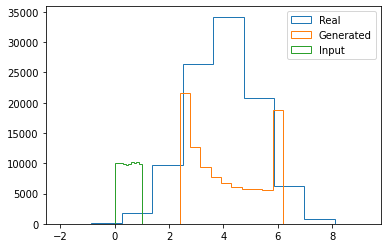

Stage 186 (Epoch: 18600)
Mean and Std of Real: (4.005362738752791, 1.2495228976743606)
Mean and Std of Gen: (4.1230226, 1.3307849)


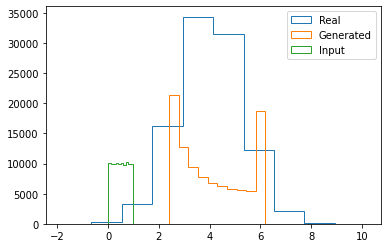

Stage 187 (Epoch: 18700)
Mean and Std of Real: (4.010431160457549, 1.2496340125212748)
Mean and Std of Gen: (4.1226954, 1.332363)


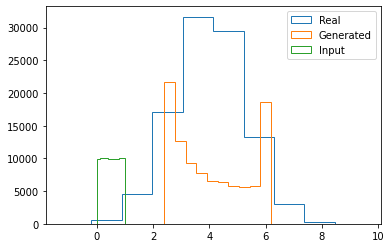

Stage 188 (Epoch: 18800)
Mean and Std of Real: (3.9973482023747713, 1.244753794748045)
Mean and Std of Gen: (4.1243024, 1.3326998)


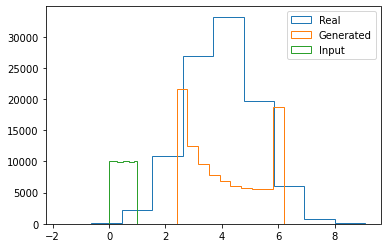

Stage 189 (Epoch: 18900)
Mean and Std of Real: (3.9994837966359897, 1.251056625679709)
Mean and Std of Gen: (4.120564, 1.3323299)


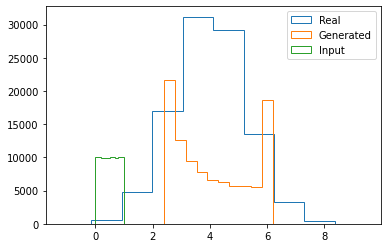

Stage 190 (Epoch: 19000)
Mean and Std of Real: (3.9958884610451055, 1.256395665894677)
Mean and Std of Gen: (4.1169705, 1.3303435)


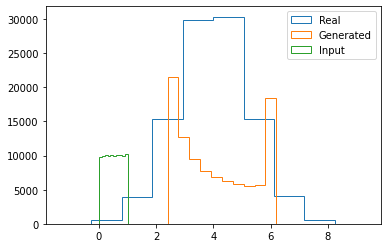

Stage 191 (Epoch: 19100)
Mean and Std of Real: (4.006353090763295, 1.246235629956965)
Mean and Std of Gen: (4.122419, 1.3326299)


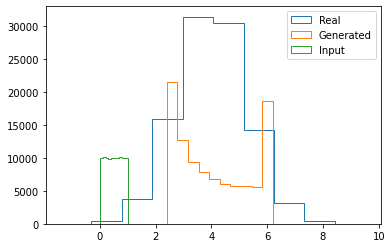

Stage 192 (Epoch: 19200)
Mean and Std of Real: (4.0018680481002065, 1.248593177269017)
Mean and Std of Gen: (4.125008, 1.3317884)


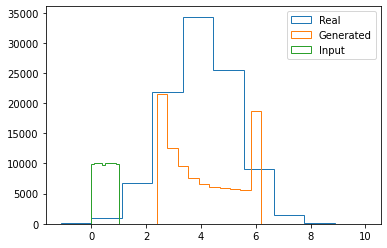

Stage 193 (Epoch: 19300)
Mean and Std of Real: (3.9970367728343037, 1.2511094201442219)
Mean and Std of Gen: (4.127486, 1.330777)


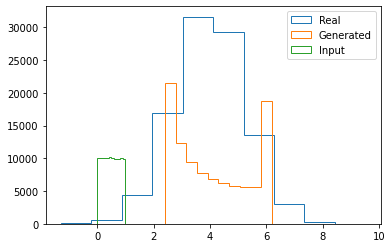

Stage 194 (Epoch: 19400)
Mean and Std of Real: (3.9985176886078158, 1.2482736082544998)
Mean and Std of Gen: (4.121678, 1.3322666)


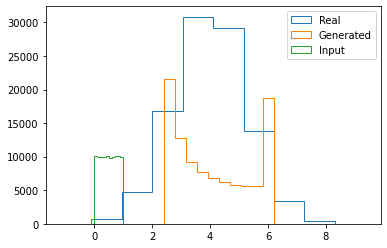

Stage 195 (Epoch: 19500)
Mean and Std of Real: (3.9945781791272643, 1.2476166857484954)
Mean and Std of Gen: (4.119112, 1.3295935)


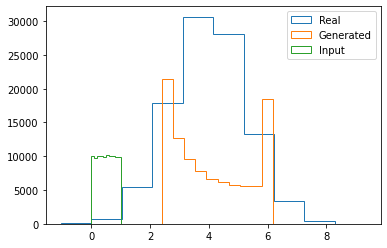

Stage 196 (Epoch: 19600)
Mean and Std of Real: (4.009768146730347, 1.2482027569427434)
Mean and Std of Gen: (4.1235557, 1.3318835)


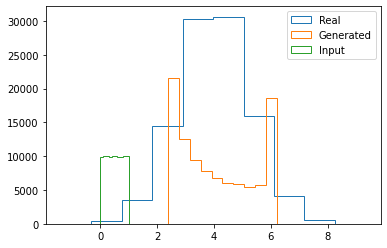

Stage 197 (Epoch: 19700)
Mean and Std of Real: (4.004746414212162, 1.250592679335856)
Mean and Std of Gen: (4.122653, 1.329323)


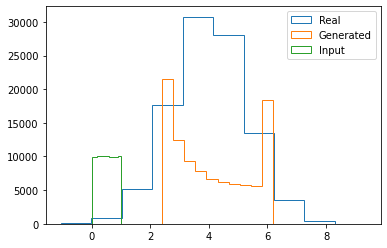

Stage 198 (Epoch: 19800)
Mean and Std of Real: (3.9961055440182838, 1.2511911258875967)
Mean and Std of Gen: (4.118593, 1.3310932)


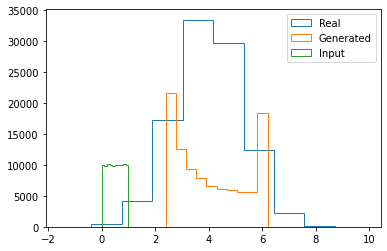

Stage 199 (Epoch: 19900)
Mean and Std of Real: (3.9979837261298323, 1.2476778747701536)
Mean and Std of Gen: (4.1249743, 1.3316841)


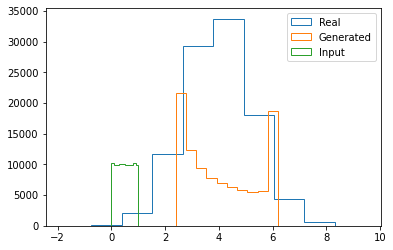

Stage 200 (Epoch: 20000)
Mean and Std of Real: (3.995486552967364, 1.2467287897419632)
Mean and Std of Gen: (4.1203628, 1.3317463)


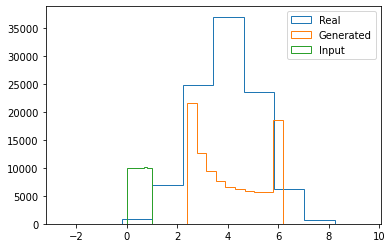

Stage 201 (Epoch: 20100)
Mean and Std of Real: (3.9970900663575413, 1.248208711935085)
Mean and Std of Gen: (4.1238017, 1.3312391)


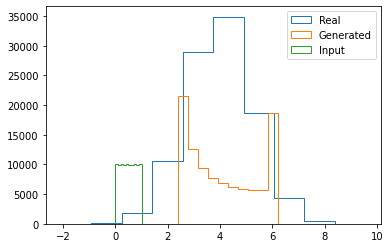

Stage 202 (Epoch: 20200)
Mean and Std of Real: (4.000526664037269, 1.2475487745234033)
Mean and Std of Gen: (4.122318, 1.329809)


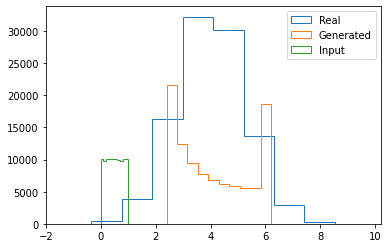

Stage 203 (Epoch: 20300)
Mean and Std of Real: (4.002440390569585, 1.2492751495809795)
Mean and Std of Gen: (4.11877, 1.3310716)


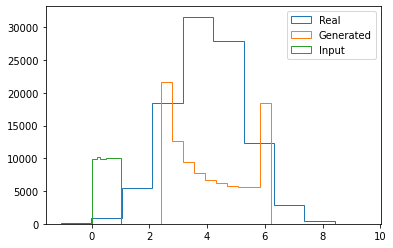

Stage 204 (Epoch: 20400)
Mean and Std of Real: (3.9981566733455662, 1.2477574626654486)
Mean and Std of Gen: (4.1272883, 1.3340405)


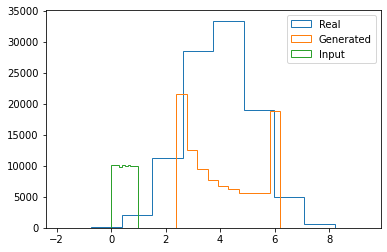

Stage 205 (Epoch: 20500)
Mean and Std of Real: (3.9959452660395995, 1.2509180625358054)
Mean and Std of Gen: (4.121707, 1.3302319)


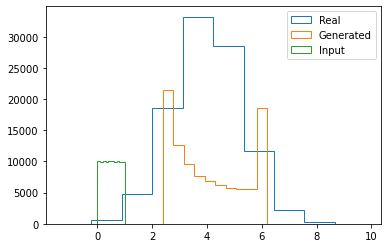

Stage 206 (Epoch: 20600)
Mean and Std of Real: (4.00135577729081, 1.2488769790650531)
Mean and Std of Gen: (4.118413, 1.3327453)


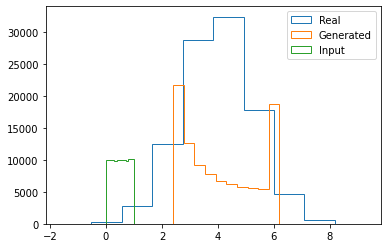

Stage 207 (Epoch: 20700)
Mean and Std of Real: (4.000363868151178, 1.2517910608525276)
Mean and Std of Gen: (4.1248155, 1.3312263)


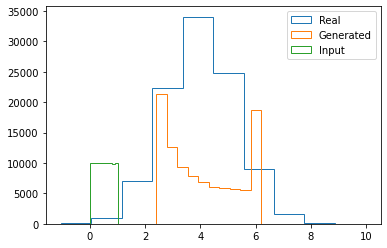

Stage 208 (Epoch: 20800)
Mean and Std of Real: (3.9956196953828162, 1.2527574122416318)
Mean and Std of Gen: (4.123496, 1.3323172)


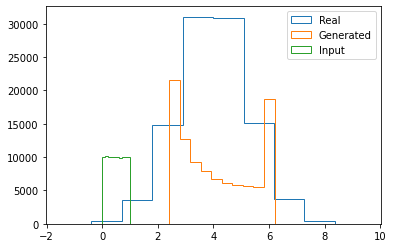

Stage 209 (Epoch: 20900)
Mean and Std of Real: (4.0024770094709545, 1.2497752369710542)
Mean and Std of Gen: (4.1258774, 1.3315077)


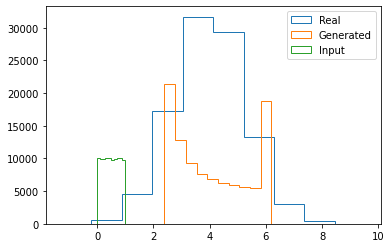

Stage 210 (Epoch: 21000)
Mean and Std of Real: (3.9929832410800676, 1.2465382543445556)
Mean and Std of Gen: (4.1173224, 1.3304398)


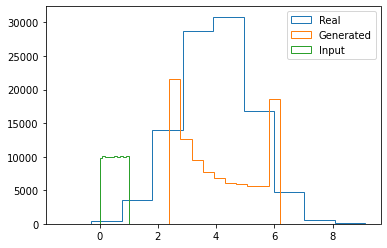

Stage 211 (Epoch: 21100)
Mean and Std of Real: (4.000885942370227, 1.2551754705144424)
Mean and Std of Gen: (4.1251426, 1.3298225)


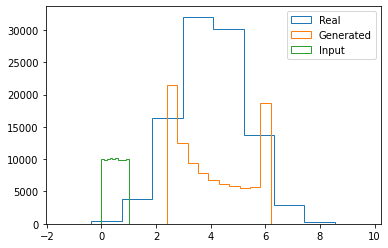

Stage 212 (Epoch: 21200)
Mean and Std of Real: (4.002484517878433, 1.2474368921940493)
Mean and Std of Gen: (4.1198473, 1.3294415)


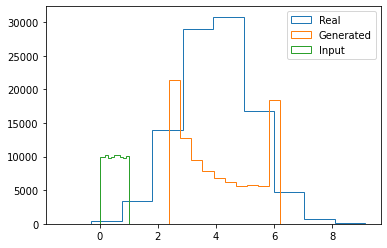

Stage 213 (Epoch: 21300)
Mean and Std of Real: (4.007399976461162, 1.2515654126030817)
Mean and Std of Gen: (4.117071, 1.3311396)


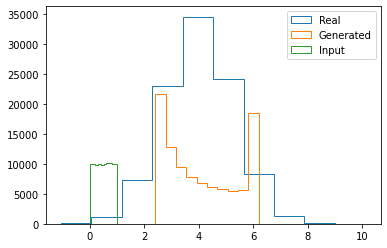

Stage 214 (Epoch: 21400)
Mean and Std of Real: (3.9968933505253874, 1.2519409024046866)
Mean and Std of Gen: (4.1184897, 1.3275357)


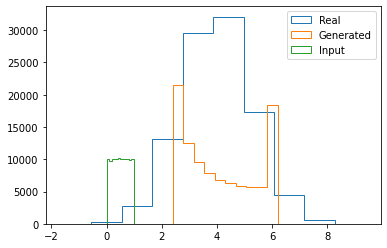

Stage 215 (Epoch: 21500)
Mean and Std of Real: (4.008481060646082, 1.2462985231916803)
Mean and Std of Gen: (4.127546, 1.3319095)


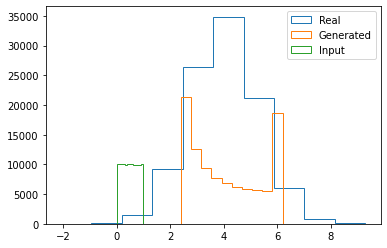

Stage 216 (Epoch: 21600)
Mean and Std of Real: (4.000896100013488, 1.2553600877291529)
Mean and Std of Gen: (4.12096, 1.3299052)


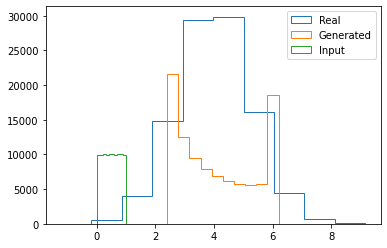

Stage 217 (Epoch: 21700)
Mean and Std of Real: (3.9963146856036578, 1.246672737099532)
Mean and Std of Gen: (4.1239176, 1.3326087)


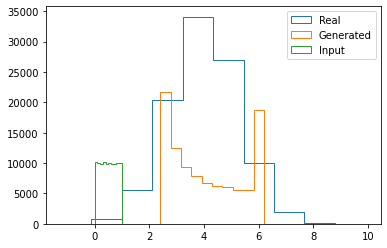

Stage 218 (Epoch: 21800)
Mean and Std of Real: (4.003962702834772, 1.2493913027102488)
Mean and Std of Gen: (4.1253605, 1.3309634)


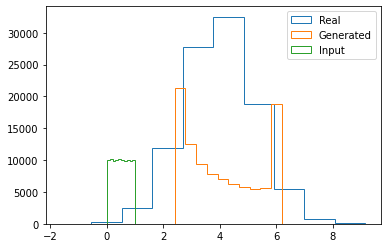

Stage 219 (Epoch: 21900)
Mean and Std of Real: (4.002788298165172, 1.254066772383776)
Mean and Std of Gen: (4.114064, 1.3312308)


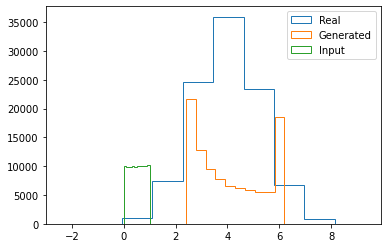

Stage 220 (Epoch: 22000)
Mean and Std of Real: (3.996122229207, 1.2521478898744893)
Mean and Std of Gen: (4.117781, 1.3313291)


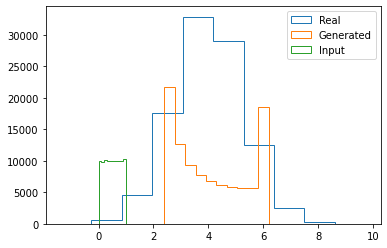

Stage 221 (Epoch: 22100)
Mean and Std of Real: (4.002084927473825, 1.2559954597563792)
Mean and Std of Gen: (4.11899, 1.3313788)


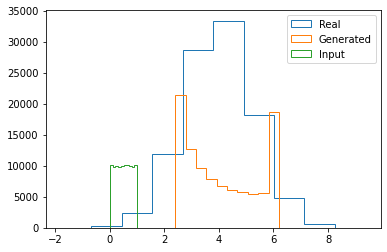

Stage 222 (Epoch: 22200)
Mean and Std of Real: (4.004491342387991, 1.246163753534685)
Mean and Std of Gen: (4.1176324, 1.3327788)


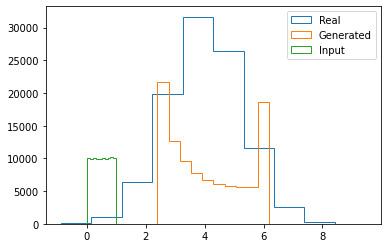

Stage 223 (Epoch: 22300)
Mean and Std of Real: (3.9996662107407626, 1.2478897021343593)
Mean and Std of Gen: (4.11986, 1.333316)


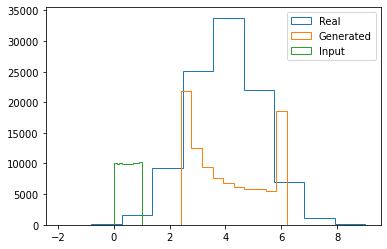

Stage 224 (Epoch: 22400)
Mean and Std of Real: (3.9959529062095394, 1.2469097960133537)
Mean and Std of Gen: (4.124209, 1.3328009)


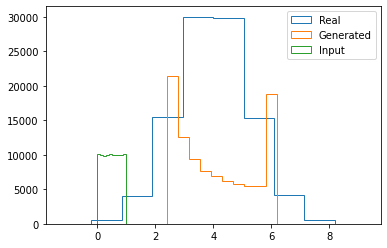

Stage 225 (Epoch: 22500)
Mean and Std of Real: (4.003854622597815, 1.2531013294589817)
Mean and Std of Gen: (4.1231227, 1.3298225)


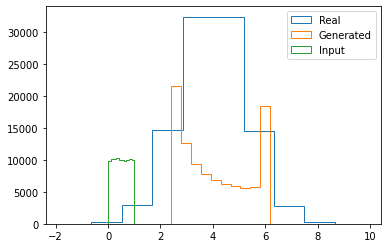

Stage 226 (Epoch: 22600)
Mean and Std of Real: (4.003262665508817, 1.2484536764190906)
Mean and Std of Gen: (4.1142745, 1.3295559)


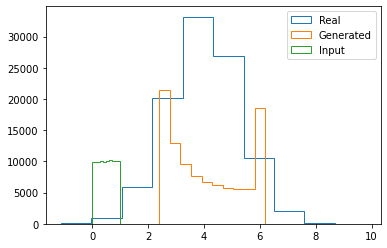

Stage 227 (Epoch: 22700)
Mean and Std of Real: (4.00047347318732, 1.2461183112853216)
Mean and Std of Gen: (4.118944, 1.3295828)


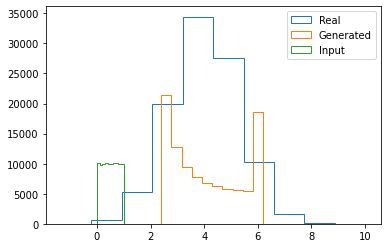

Stage 228 (Epoch: 22800)
Mean and Std of Real: (4.004210150039706, 1.2495593715789317)
Mean and Std of Gen: (4.122444, 1.3321823)


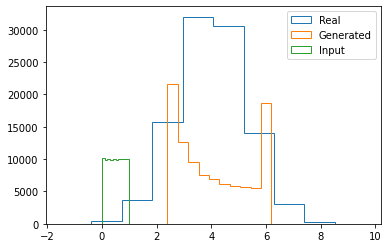

Stage 229 (Epoch: 22900)
Mean and Std of Real: (4.002872891604301, 1.2505270846258567)
Mean and Std of Gen: (4.1233764, 1.330817)


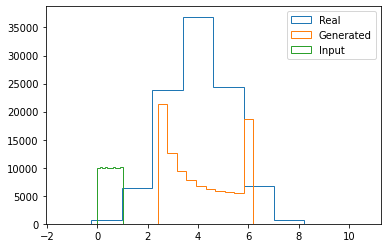

Stage 230 (Epoch: 23000)
Mean and Std of Real: (3.997989361118482, 1.2453971061633238)
Mean and Std of Gen: (4.1259255, 1.3327382)


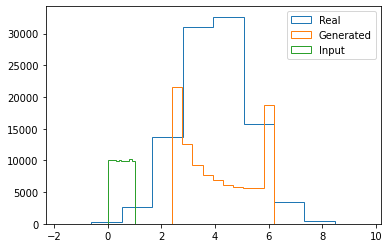

Stage 231 (Epoch: 23100)
Mean and Std of Real: (4.000096258149544, 1.249918671262664)
Mean and Std of Gen: (4.1226625, 1.3310761)


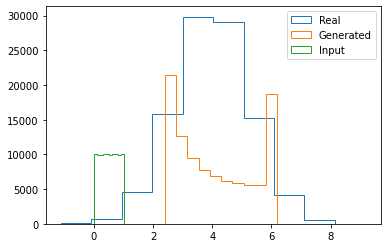

Stage 232 (Epoch: 23200)
Mean and Std of Real: (3.9983828969853827, 1.24840094916082)
Mean and Std of Gen: (4.1220613, 1.3297131)


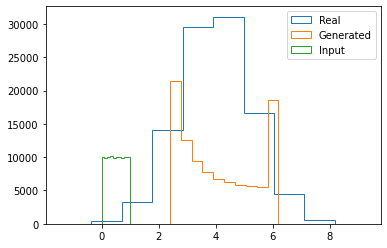

Stage 233 (Epoch: 23300)
Mean and Std of Real: (4.00164626247896, 1.2481500453235759)
Mean and Std of Gen: (4.119273, 1.3303257)


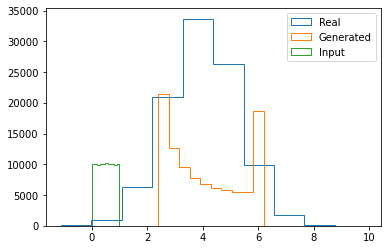

Stage 234 (Epoch: 23400)
Mean and Std of Real: (4.002555919694631, 1.2503031035412666)
Mean and Std of Gen: (4.115872, 1.3286681)


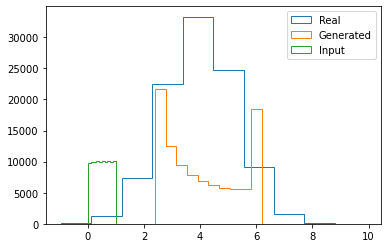

Stage 235 (Epoch: 23500)
Mean and Std of Real: (3.996645522709484, 1.2533258772793427)
Mean and Std of Gen: (4.116857, 1.3288238)


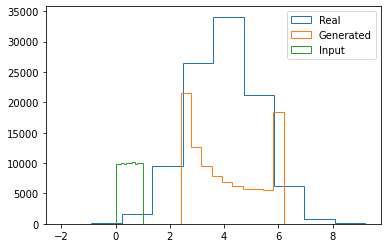

Stage 236 (Epoch: 23600)
Mean and Std of Real: (4.001489430109139, 1.253033254877483)
Mean and Std of Gen: (4.1189613, 1.3296561)


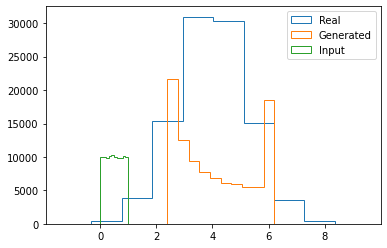

Stage 237 (Epoch: 23700)
Mean and Std of Real: (4.004771435265797, 1.250064916005009)
Mean and Std of Gen: (4.124803, 1.3327503)


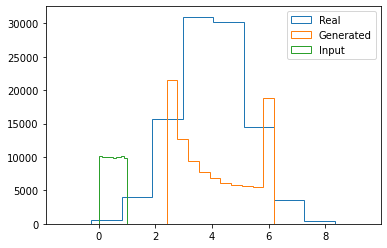

Stage 238 (Epoch: 23800)
Mean and Std of Real: (3.997744763221013, 1.2486689638592885)
Mean and Std of Gen: (4.1304083, 1.3340497)


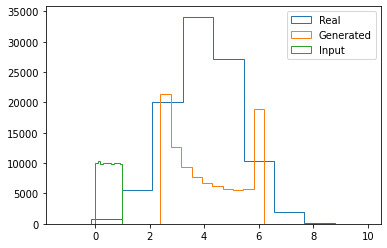

Stage 239 (Epoch: 23900)
Mean and Std of Real: (3.9955996512012364, 1.2483338161413167)
Mean and Std of Gen: (4.11911, 1.3307158)


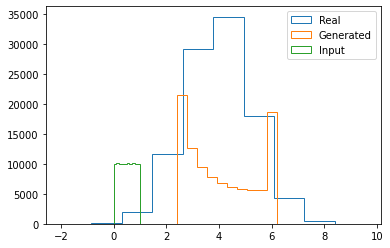

Stage 240 (Epoch: 24000)
Mean and Std of Real: (3.9988162588408915, 1.2590715070356744)
Mean and Std of Gen: (4.127233, 1.3313547)


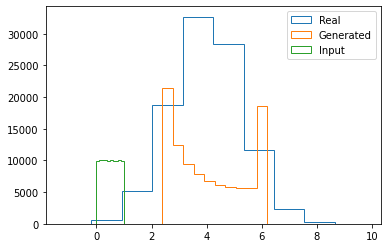

Stage 241 (Epoch: 24100)
Mean and Std of Real: (4.00246659031693, 1.252142700437691)
Mean and Std of Gen: (4.1296964, 1.3302644)


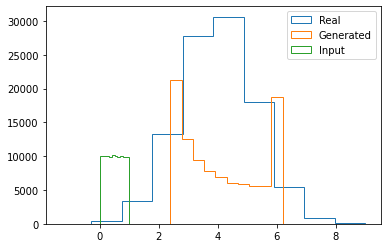

Stage 242 (Epoch: 24200)
Mean and Std of Real: (4.000575557702656, 1.2523146048433398)
Mean and Std of Gen: (4.1170816, 1.3297684)


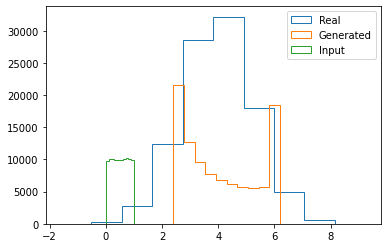

Stage 243 (Epoch: 24300)
Mean and Std of Real: (4.007201993160177, 1.2512316009915225)
Mean and Std of Gen: (4.122945, 1.3319993)


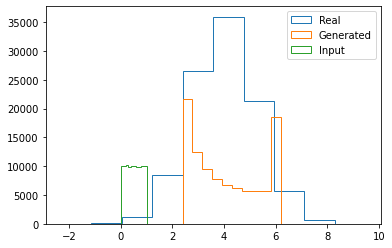

Stage 244 (Epoch: 24400)
Mean and Std of Real: (3.9994944167873236, 1.2481218287352358)
Mean and Std of Gen: (4.119484, 1.3305675)


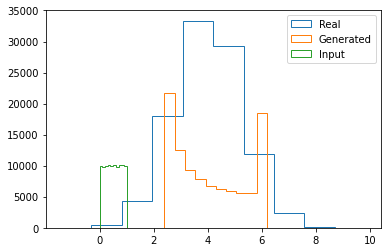

Stage 245 (Epoch: 24500)
Mean and Std of Real: (3.9990762471228094, 1.250383295889599)
Mean and Std of Gen: (4.1255345, 1.3285881)


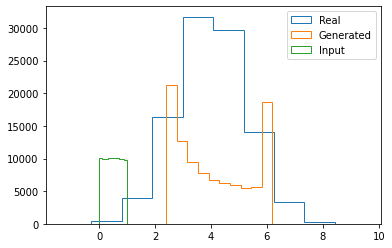

Stage 246 (Epoch: 24600)
Mean and Std of Real: (3.9962657384855875, 1.2529011781739414)
Mean and Std of Gen: (4.1165724, 1.3323808)


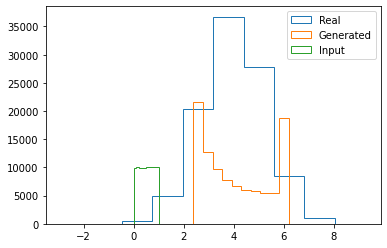

Stage 247 (Epoch: 24700)
Mean and Std of Real: (4.001968396094444, 1.2481843004984383)
Mean and Std of Gen: (4.1253414, 1.333152)


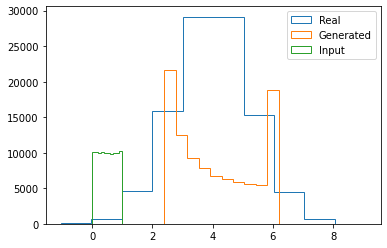

Stage 248 (Epoch: 24800)
Mean and Std of Real: (3.999545562587739, 1.2457864451690135)
Mean and Std of Gen: (4.1209593, 1.331499)


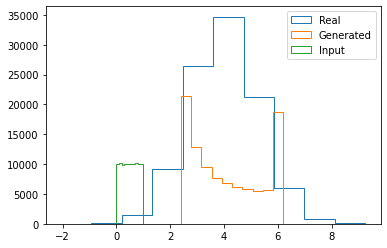

Stage 249 (Epoch: 24900)
Mean and Std of Real: (3.999550600046687, 1.254939391747013)
Mean and Std of Gen: (4.127349, 1.3321532)


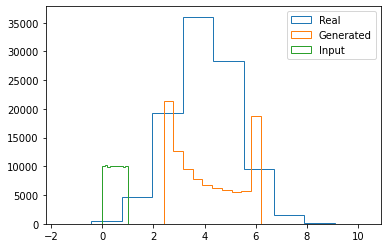

Stage 250 (Epoch: 25000)
Mean and Std of Real: (4.0001445259796045, 1.2522484091838793)
Mean and Std of Gen: (4.1196027, 1.3320395)


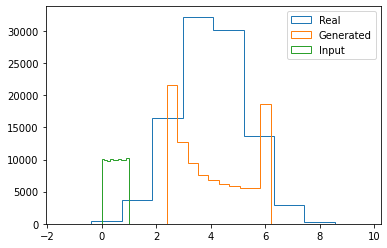

Stage 251 (Epoch: 25100)
Mean and Std of Real: (4.002399763674165, 1.252894696586994)
Mean and Std of Gen: (4.1294756, 1.3317997)


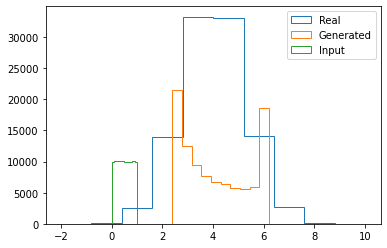

Stage 252 (Epoch: 25200)
Mean and Std of Real: (4.000262597374713, 1.2492261120731756)
Mean and Std of Gen: (4.120656, 1.3338907)


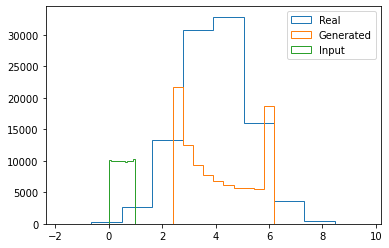

Stage 253 (Epoch: 25300)
Mean and Std of Real: (3.997863773475787, 1.254130146714961)
Mean and Std of Gen: (4.1215463, 1.333543)


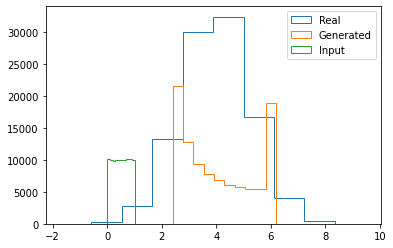

Stage 254 (Epoch: 25400)
Mean and Std of Real: (3.9959257797333736, 1.2481829284358326)
Mean and Std of Gen: (4.1121, 1.3264514)


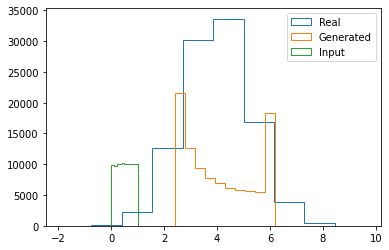

Stage 255 (Epoch: 25500)
Mean and Std of Real: (4.002198741841885, 1.2455770793977339)
Mean and Std of Gen: (4.128143, 1.3323722)


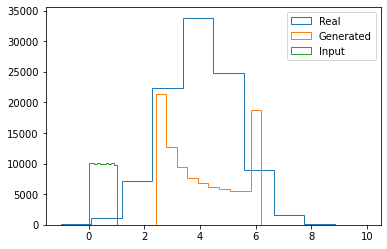

Stage 256 (Epoch: 25600)
Mean and Std of Real: (3.998897364885743, 1.2514822078646732)
Mean and Std of Gen: (4.1222763, 1.3315723)


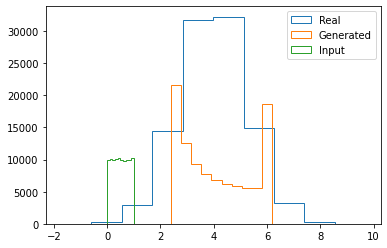

Stage 257 (Epoch: 25700)
Mean and Std of Real: (4.00667838524398, 1.25098066901091)
Mean and Std of Gen: (4.1221714, 1.3309643)


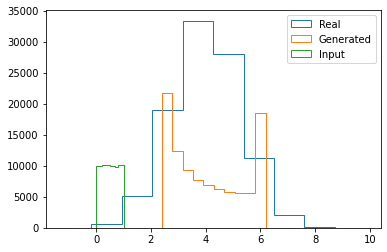

Stage 258 (Epoch: 25800)
Mean and Std of Real: (4.002204711399983, 1.254151153192057)
Mean and Std of Gen: (4.1117973, 1.3290339)


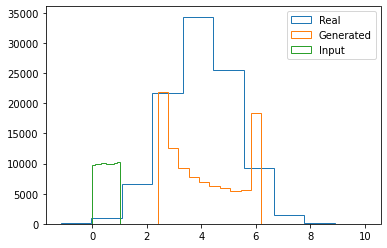

Stage 259 (Epoch: 25900)
Mean and Std of Real: (3.998131403773163, 1.2492627539446817)
Mean and Std of Gen: (4.122885, 1.3288689)


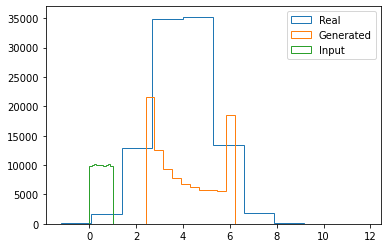

Stage 260 (Epoch: 26000)
Mean and Std of Real: (3.9988539154287985, 1.2503915646251353)
Mean and Std of Gen: (4.125986, 1.3310784)


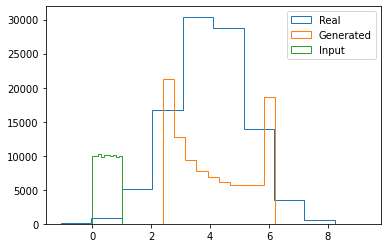

Stage 261 (Epoch: 26100)
Mean and Std of Real: (3.997375456992057, 1.2488229380828384)
Mean and Std of Gen: (4.120386, 1.3327032)


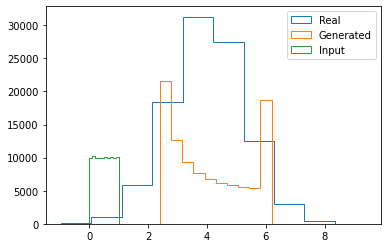

Stage 262 (Epoch: 26200)
Mean and Std of Real: (3.9980879484724503, 1.2510978586996935)
Mean and Std of Gen: (4.1234355, 1.3324238)


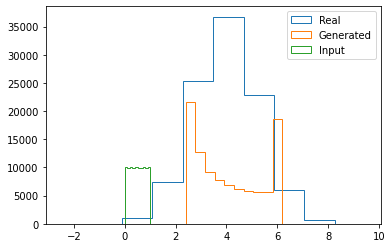

Stage 263 (Epoch: 26300)
Mean and Std of Real: (3.9962790920173594, 1.2475048961386055)
Mean and Std of Gen: (4.116666, 1.3309784)


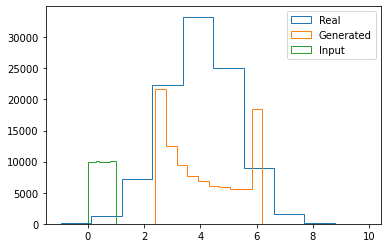

Stage 264 (Epoch: 26400)
Mean and Std of Real: (3.990294166456578, 1.2501959583233972)
Mean and Std of Gen: (4.1179075, 1.331053)


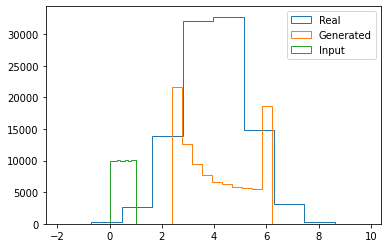

Stage 265 (Epoch: 26500)
Mean and Std of Real: (4.004783718124473, 1.2491954818589375)
Mean and Std of Gen: (4.12474, 1.3312063)


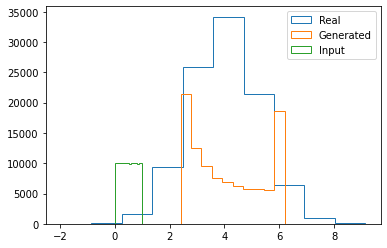

Stage 266 (Epoch: 26600)
Mean and Std of Real: (3.9945227472071823, 1.2498360862446507)
Mean and Std of Gen: (4.121715, 1.3294034)


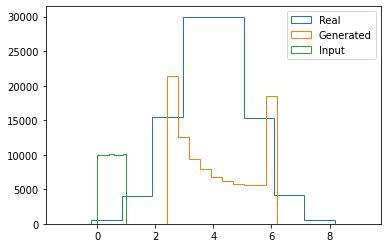

Stage 267 (Epoch: 26700)
Mean and Std of Real: (4.00079177027826, 1.2468925977173726)
Mean and Std of Gen: (4.1242824, 1.3322335)


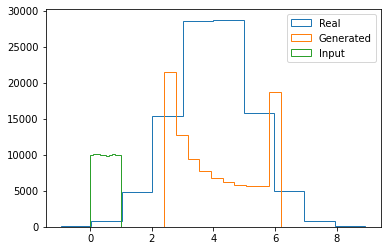

Stage 268 (Epoch: 26800)
Mean and Std of Real: (3.993813899167903, 1.2475187756738029)
Mean and Std of Gen: (4.1286545, 1.3325427)


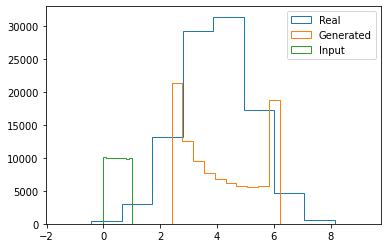

Stage 269 (Epoch: 26900)
Mean and Std of Real: (4.003470955084177, 1.253242932495375)
Mean and Std of Gen: (4.113868, 1.3289956)


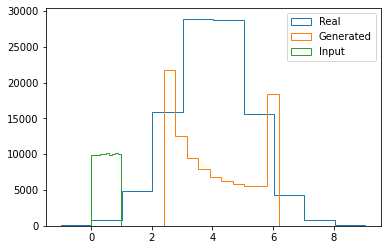

Stage 270 (Epoch: 27000)
Mean and Std of Real: (4.003527700993443, 1.2537674541076078)
Mean and Std of Gen: (4.122246, 1.3305024)


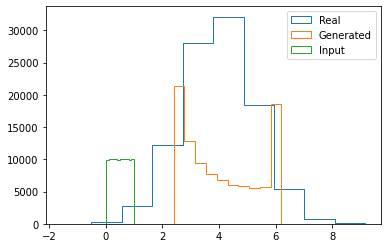

Stage 271 (Epoch: 27100)
Mean and Std of Real: (3.998461191302853, 1.2507825164949997)
Mean and Std of Gen: (4.124428, 1.3318995)


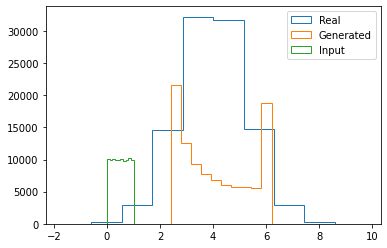

Stage 272 (Epoch: 27200)
Mean and Std of Real: (3.998889255161449, 1.2484786723571735)
Mean and Std of Gen: (4.125594, 1.3309294)


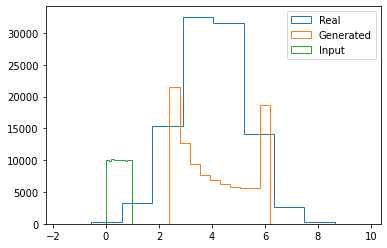

Stage 273 (Epoch: 27300)
Mean and Std of Real: (3.996134167369477, 1.2524284979223912)
Mean and Std of Gen: (4.1257915, 1.3333509)


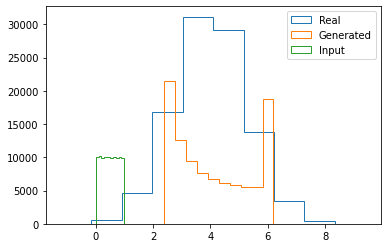

Stage 274 (Epoch: 27400)
Mean and Std of Real: (4.007987527870813, 1.2517562862563256)
Mean and Std of Gen: (4.1321063, 1.334985)


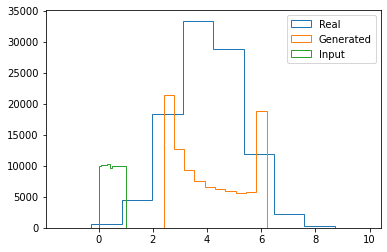

Stage 275 (Epoch: 27500)
Mean and Std of Real: (4.002555559676892, 1.2515911624957439)
Mean and Std of Gen: (4.1241407, 1.332827)


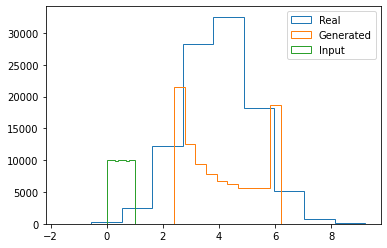

Stage 276 (Epoch: 27600)
Mean and Std of Real: (4.003316670760427, 1.2477191034047315)
Mean and Std of Gen: (4.11916, 1.3317885)


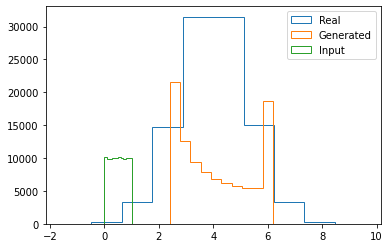

Stage 277 (Epoch: 27700)
Mean and Std of Real: (3.9975578659089037, 1.2536007201326018)
Mean and Std of Gen: (4.122014, 1.3339392)


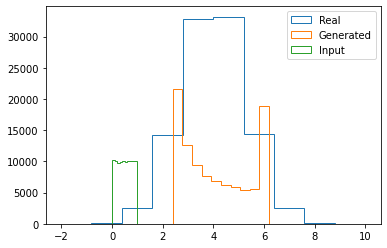

Stage 278 (Epoch: 27800)
Mean and Std of Real: (3.9948216645307384, 1.2493594833643633)
Mean and Std of Gen: (4.123475, 1.329412)


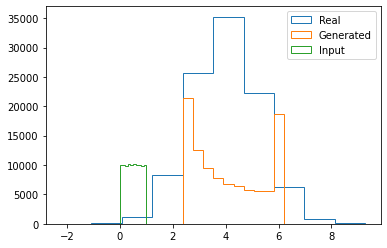

Stage 279 (Epoch: 27900)
Mean and Std of Real: (4.005302132294228, 1.2504727502441184)
Mean and Std of Gen: (4.1293664, 1.3299762)


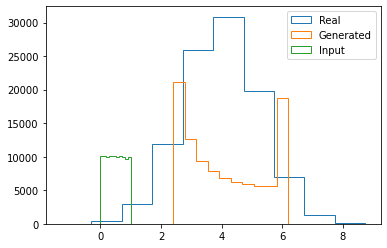

Stage 280 (Epoch: 28000)
Mean and Std of Real: (3.992801088217478, 1.2523446494140595)
Mean and Std of Gen: (4.1219687, 1.3334706)


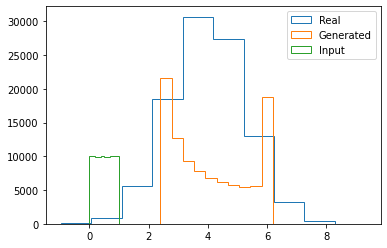

Stage 281 (Epoch: 28100)
Mean and Std of Real: (3.997136205265107, 1.2479049552059518)
Mean and Std of Gen: (4.1230774, 1.3300209)


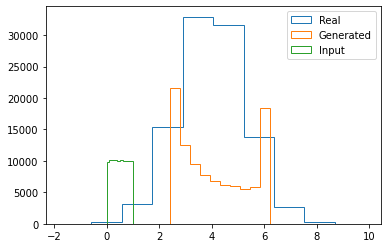

Stage 282 (Epoch: 28200)
Mean and Std of Real: (4.000456287992814, 1.250772788995176)
Mean and Std of Gen: (4.1231046, 1.3318642)


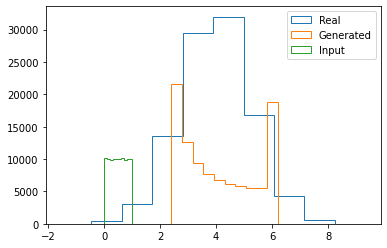

Stage 283 (Epoch: 28300)
Mean and Std of Real: (4.003539098709983, 1.2487328016005066)
Mean and Std of Gen: (4.1279683, 1.33258)


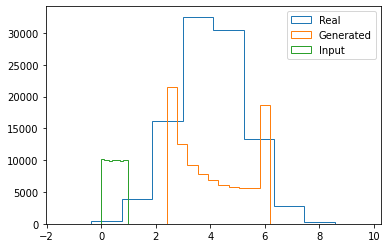

Stage 284 (Epoch: 28400)
Mean and Std of Real: (3.999890920899979, 1.2465992475841543)
Mean and Std of Gen: (4.1230516, 1.3300768)


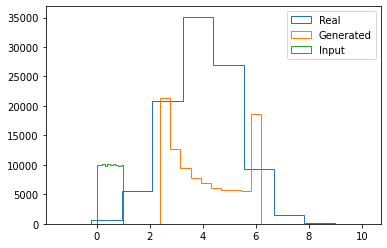

Stage 285 (Epoch: 28500)
Mean and Std of Real: (4.00145217671668, 1.2503119847069963)
Mean and Std of Gen: (4.129712, 1.3290331)


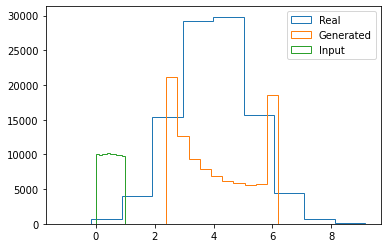

Stage 286 (Epoch: 28600)
Mean and Std of Real: (3.994173981628196, 1.2475256639373458)
Mean and Std of Gen: (4.122856, 1.3330009)


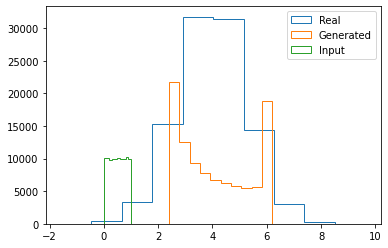

Stage 287 (Epoch: 28700)
Mean and Std of Real: (3.9970627149442364, 1.2531830560261177)
Mean and Std of Gen: (4.1267195, 1.3321261)


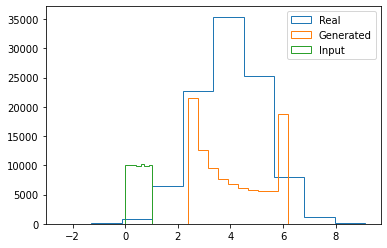

Stage 288 (Epoch: 28800)
Mean and Std of Real: (4.004543718157948, 1.251130472872911)
Mean and Std of Gen: (4.1249685, 1.3321673)


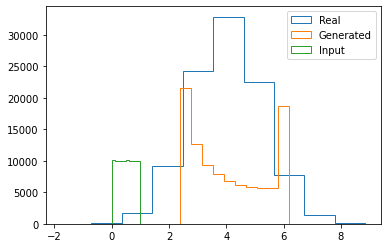

Stage 289 (Epoch: 28900)
Mean and Std of Real: (3.994993250633084, 1.2514806406271037)
Mean and Std of Gen: (4.124585, 1.3322884)


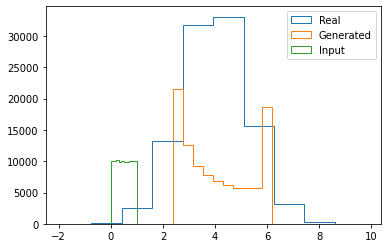

Stage 290 (Epoch: 29000)
Mean and Std of Real: (3.99991180162272, 1.2538798513611908)
Mean and Std of Gen: (4.1336985, 1.3338407)


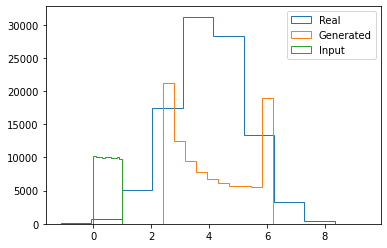

Stage 291 (Epoch: 29100)
Mean and Std of Real: (4.0010563945827275, 1.2529256613618516)
Mean and Std of Gen: (4.125111, 1.3336593)


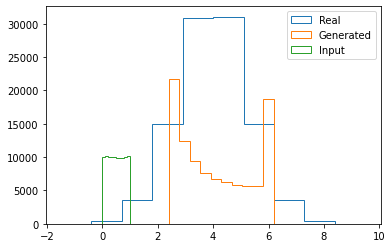

Stage 292 (Epoch: 29200)
Mean and Std of Real: (4.008295810037004, 1.2568172342969124)
Mean and Std of Gen: (4.1236277, 1.3307658)


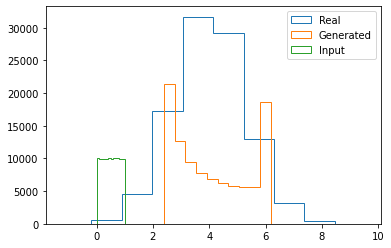

Stage 293 (Epoch: 29300)
Mean and Std of Real: (4.0053232190527766, 1.2527797977060706)
Mean and Std of Gen: (4.121212, 1.329022)


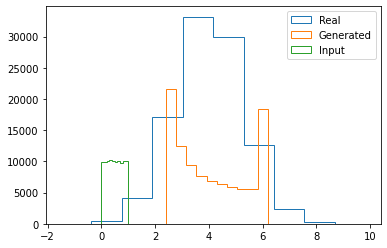

Stage 294 (Epoch: 29400)
Mean and Std of Real: (3.9995079362222716, 1.2544275938968787)
Mean and Std of Gen: (4.131195, 1.3322976)


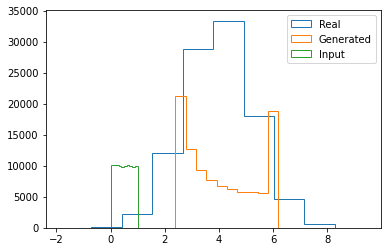

Stage 295 (Epoch: 29500)
Mean and Std of Real: (3.9949142501302966, 1.2510901212240895)
Mean and Std of Gen: (4.1291885, 1.3321463)


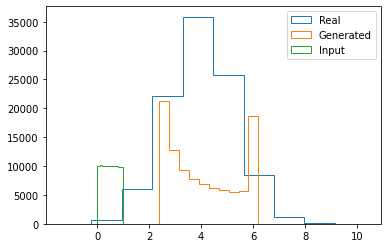

Stage 296 (Epoch: 29600)
Mean and Std of Real: (3.9976093785157403, 1.2511012471635434)
Mean and Std of Gen: (4.1219, 1.3294073)


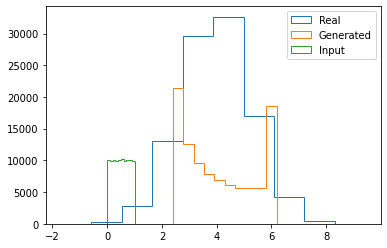

Stage 297 (Epoch: 29700)
Mean and Std of Real: (3.9994711438544215, 1.2470353229832334)
Mean and Std of Gen: (4.1226187, 1.3331245)


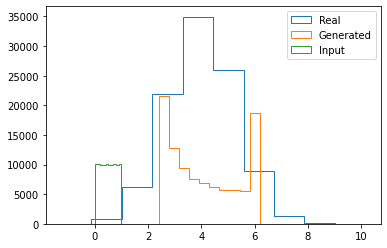

Stage 298 (Epoch: 29800)
Mean and Std of Real: (4.002077563732961, 1.2430511922717637)
Mean and Std of Gen: (4.1221905, 1.3331766)


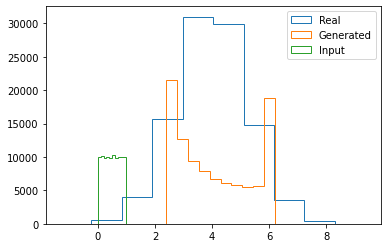

Stage 299 (Epoch: 29900)
Mean and Std of Real: (4.00133347355921, 1.2497823209158616)
Mean and Std of Gen: (4.128988, 1.3314174)


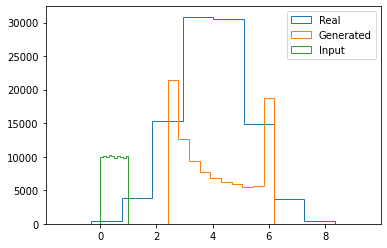

Stage 300 (Epoch: 30000)
Mean and Std of Real: (3.9990730516153103, 1.2499593766161852)
Mean and Std of Gen: (4.1165676, 1.3300626)


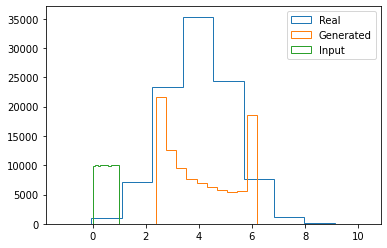

Stage 301 (Epoch: 30100)
Mean and Std of Real: (4.003540526229765, 1.2540384865810157)
Mean and Std of Gen: (4.118619, 1.33249)


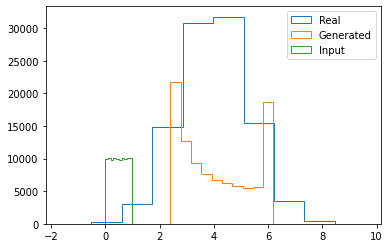

Stage 302 (Epoch: 30200)
Mean and Std of Real: (3.998943507827259, 1.2507629995666605)
Mean and Std of Gen: (4.1161976, 1.3305255)


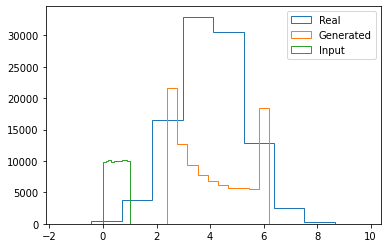

Stage 303 (Epoch: 30300)
Mean and Std of Real: (4.0062041596683775, 1.2520103673650036)
Mean and Std of Gen: (4.1251364, 1.3327872)


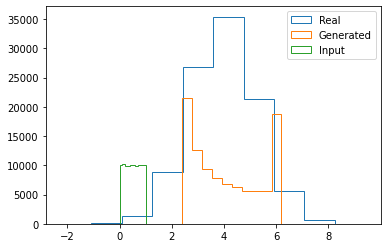

Stage 304 (Epoch: 30400)
Mean and Std of Real: (3.9962143873795064, 1.2481213147281311)
Mean and Std of Gen: (4.1278567, 1.3309648)


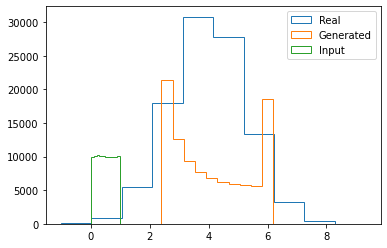

Stage 305 (Epoch: 30500)
Mean and Std of Real: (4.002929863654431, 1.2470760374124252)
Mean and Std of Gen: (4.1173964, 1.3294196)


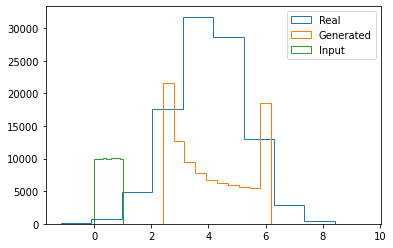

Stage 306 (Epoch: 30600)
Mean and Std of Real: (3.997972885450261, 1.2507502894634792)
Mean and Std of Gen: (4.1218777, 1.329894)


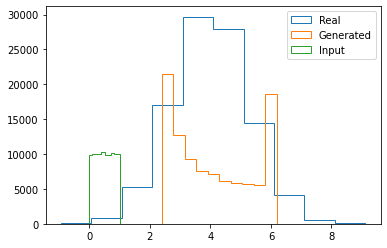

Stage 307 (Epoch: 30700)
Mean and Std of Real: (3.9983161601684865, 1.2514981820778996)
Mean and Std of Gen: (4.1175733, 1.329672)


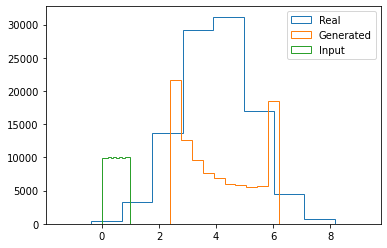

Stage 308 (Epoch: 30800)
Mean and Std of Real: (4.002516866004717, 1.249944825267485)
Mean and Std of Gen: (4.1233106, 1.3304104)


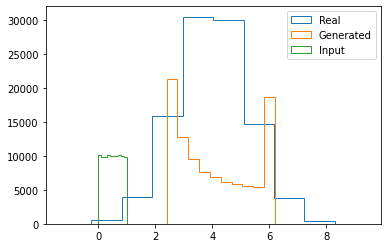

Stage 309 (Epoch: 30900)
Mean and Std of Real: (3.9990118899384446, 1.2507164327187088)
Mean and Std of Gen: (4.1230245, 1.3306653)


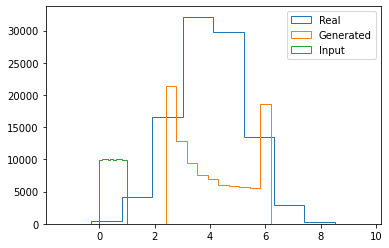

Stage 310 (Epoch: 31000)
Mean and Std of Real: (3.9933207755135394, 1.2466104111023)
Mean and Std of Gen: (4.1200156, 1.3308637)


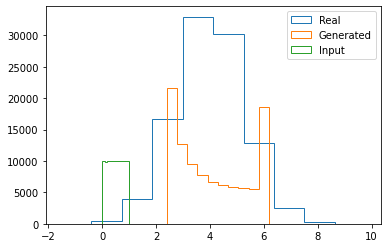

Stage 311 (Epoch: 31100)
Mean and Std of Real: (3.998982899869272, 1.2504648424081228)
Mean and Std of Gen: (4.1253343, 1.3344451)


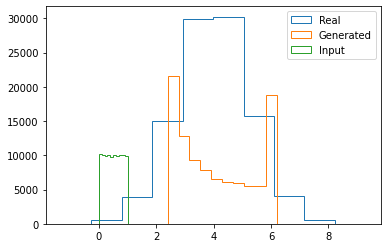

Stage 312 (Epoch: 31200)
Mean and Std of Real: (3.9953964296026303, 1.2449188000132398)
Mean and Std of Gen: (4.1310096, 1.3329954)


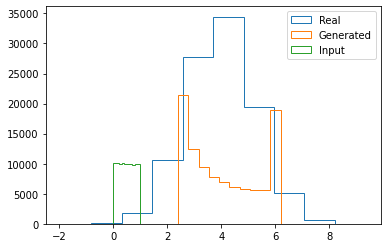

Stage 313 (Epoch: 31300)
Mean and Std of Real: (3.999793228393479, 1.2526609290217043)
Mean and Std of Gen: (4.121262, 1.3292183)


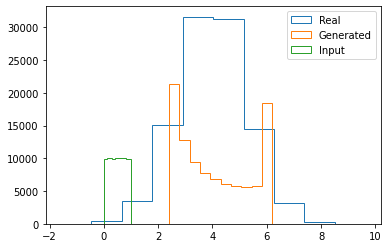

Stage 314 (Epoch: 31400)
Mean and Std of Real: (4.000491661808989, 1.2466857693679405)
Mean and Std of Gen: (4.1220536, 1.3305165)


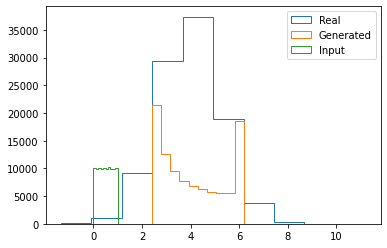

Stage 315 (Epoch: 31500)
Mean and Std of Real: (3.992694785496695, 1.252165644120843)
Mean and Std of Gen: (4.1183167, 1.3296252)


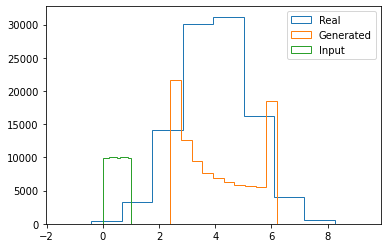

Stage 316 (Epoch: 31600)
Mean and Std of Real: (3.993493058063978, 1.249480581330073)
Mean and Std of Gen: (4.1288133, 1.3348399)


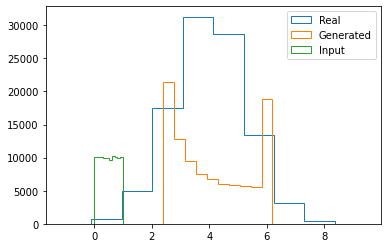

Stage 317 (Epoch: 31700)
Mean and Std of Real: (4.005710233586237, 1.252807242875111)
Mean and Std of Gen: (4.1155586, 1.3322345)


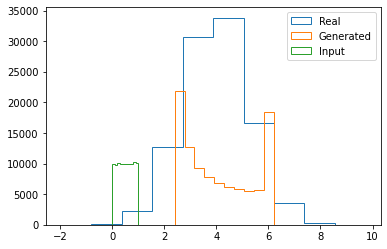

Stage 318 (Epoch: 31800)
Mean and Std of Real: (4.002347347901903, 1.2515481101863366)
Mean and Std of Gen: (4.1282005, 1.3302604)


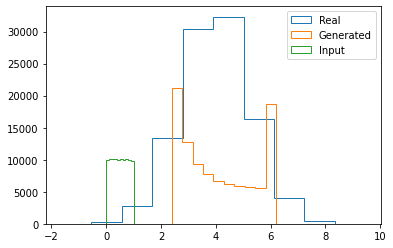

Stage 319 (Epoch: 31900)
Mean and Std of Real: (4.000843657991202, 1.2462118415389432)
Mean and Std of Gen: (4.1181364, 1.3314482)


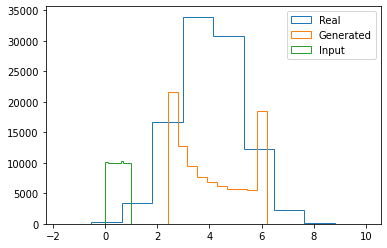

Stage 320 (Epoch: 32000)
Mean and Std of Real: (3.9953407194345387, 1.2511891254383198)
Mean and Std of Gen: (4.1249976, 1.3331698)


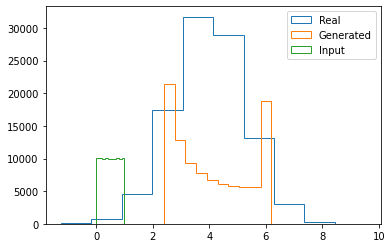

Stage 321 (Epoch: 32100)
Mean and Std of Real: (4.002991783981619, 1.246508019210371)
Mean and Std of Gen: (4.124561, 1.3326998)


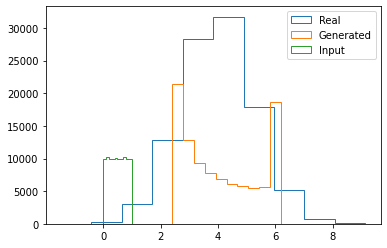

Stage 322 (Epoch: 32200)
Mean and Std of Real: (4.00086633511653, 1.2482869602935596)
Mean and Std of Gen: (4.1242514, 1.3324183)


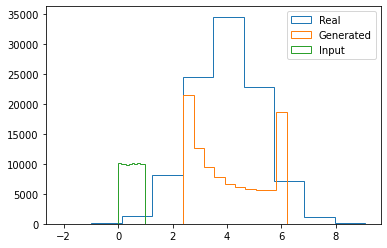

Stage 323 (Epoch: 32300)
Mean and Std of Real: (3.9993157822669243, 1.246860085753645)
Mean and Std of Gen: (4.11338, 1.3309394)


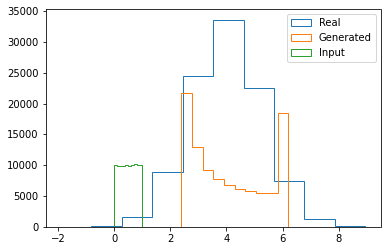

Stage 324 (Epoch: 32400)
Mean and Std of Real: (4.000423708865323, 1.251881845119308)
Mean and Std of Gen: (4.1294923, 1.3324711)


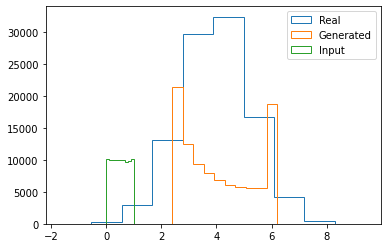

Stage 325 (Epoch: 32500)
Mean and Std of Real: (4.000754289071391, 1.2536650492459216)
Mean and Std of Gen: (4.1204076, 1.3310258)


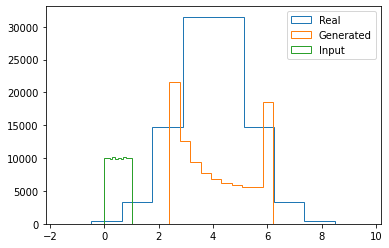

Stage 326 (Epoch: 32600)
Mean and Std of Real: (3.9902613052435925, 1.2473452561660692)
Mean and Std of Gen: (4.122893, 1.3328134)


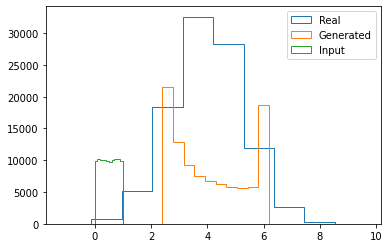

Stage 327 (Epoch: 32700)
Mean and Std of Real: (4.001812864779258, 1.2494945612856034)
Mean and Std of Gen: (4.120385, 1.3286805)


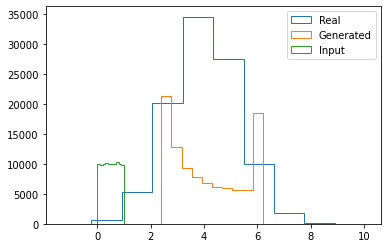

Stage 328 (Epoch: 32800)
Mean and Std of Real: (3.9943062753350533, 1.250284766529545)
Mean and Std of Gen: (4.123632, 1.3336992)


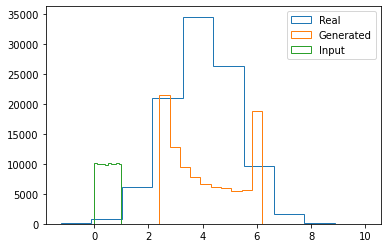

Stage 329 (Epoch: 32900)
Mean and Std of Real: (3.998674764762475, 1.2528809523480486)
Mean and Std of Gen: (4.1288233, 1.3360811)


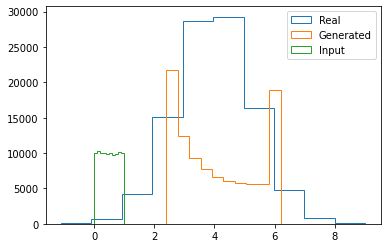

Stage 330 (Epoch: 33000)
Mean and Std of Real: (4.0009795217568795, 1.250573310859431)
Mean and Std of Gen: (4.120153, 1.3293551)


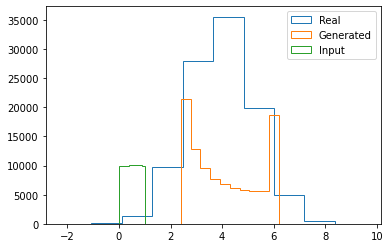

Stage 331 (Epoch: 33100)
Mean and Std of Real: (4.006347270551469, 1.2499281413984602)
Mean and Std of Gen: (4.1147013, 1.3292469)


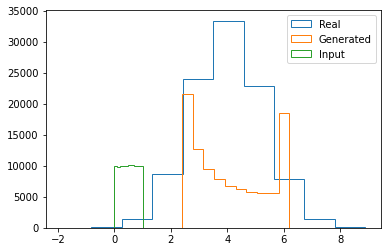

Stage 332 (Epoch: 33200)
Mean and Std of Real: (4.00120858916333, 1.2488007202354998)
Mean and Std of Gen: (4.1223607, 1.3304003)


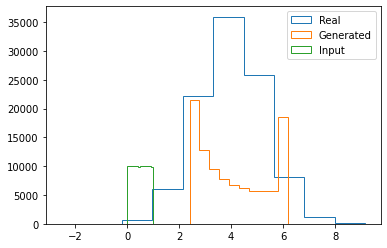

Stage 333 (Epoch: 33300)
Mean and Std of Real: (3.9943777201325683, 1.248616031205843)
Mean and Std of Gen: (4.12754, 1.3320508)


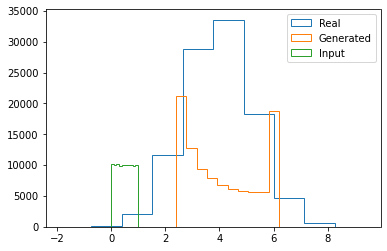

Stage 334 (Epoch: 33400)
Mean and Std of Real: (4.0006235653456805, 1.2507061395644112)
Mean and Std of Gen: (4.124714, 1.3302833)


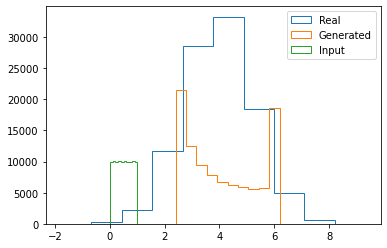

Stage 335 (Epoch: 33500)
Mean and Std of Real: (3.9962875217603373, 1.2555495923773976)
Mean and Std of Gen: (4.1192307, 1.3333306)


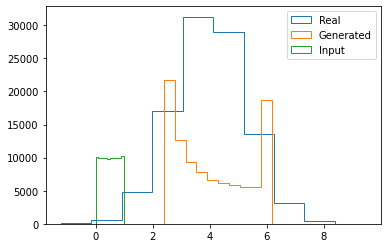

Stage 336 (Epoch: 33600)
Mean and Std of Real: (4.000062761154634, 1.2485520784011224)
Mean and Std of Gen: (4.120927, 1.33015)


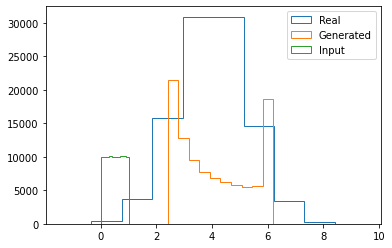

Stage 337 (Epoch: 33700)
Mean and Std of Real: (3.9924556927682366, 1.2517168979704052)
Mean and Std of Gen: (4.124959, 1.3299993)


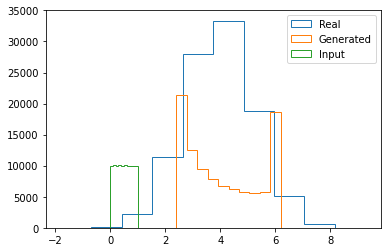

Stage 338 (Epoch: 33800)
Mean and Std of Real: (4.004741852652214, 1.2509554490547579)
Mean and Std of Gen: (4.1184955, 1.3320886)


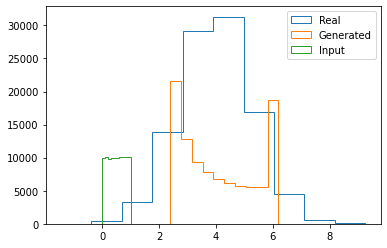

Stage 339 (Epoch: 33900)
Mean and Std of Real: (4.002181988456223, 1.246891868137003)
Mean and Std of Gen: (4.123678, 1.3338896)


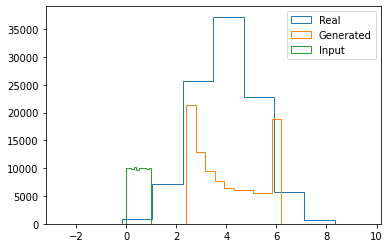

Stage 340 (Epoch: 34000)
Mean and Std of Real: (4.000860578679888, 1.255391807578154)
Mean and Std of Gen: (4.1220427, 1.3286761)


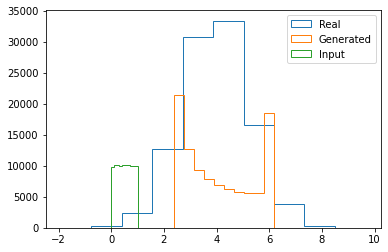

Stage 341 (Epoch: 34100)
Mean and Std of Real: (4.007284840676429, 1.2478898251364383)
Mean and Std of Gen: (4.1253557, 1.3331015)


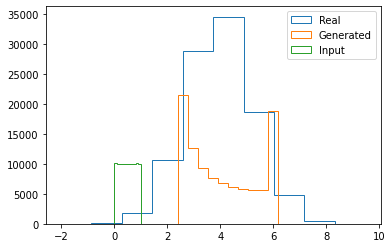

Stage 342 (Epoch: 34200)
Mean and Std of Real: (3.9929739618886284, 1.2500617879515143)
Mean and Std of Gen: (4.121001, 1.3316487)


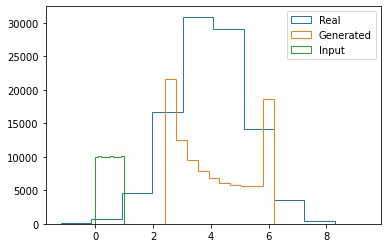

Stage 343 (Epoch: 34300)
Mean and Std of Real: (3.9930102811006525, 1.2522140659736165)
Mean and Std of Gen: (4.122237, 1.3316776)


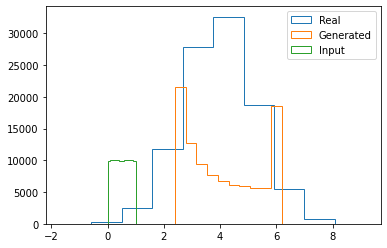

Stage 344 (Epoch: 34400)
Mean and Std of Real: (3.99935439422698, 1.2532407416825118)
Mean and Std of Gen: (4.1227603, 1.3306822)


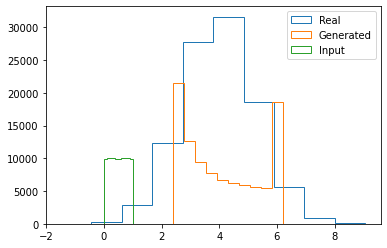

Stage 345 (Epoch: 34500)
Mean and Std of Real: (3.990941587018189, 1.2537972468188834)
Mean and Std of Gen: (4.126652, 1.3350405)


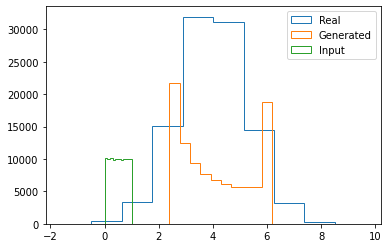

Stage 346 (Epoch: 34600)
Mean and Std of Real: (3.9982681365298025, 1.2549094225666395)
Mean and Std of Gen: (4.120723, 1.3318232)


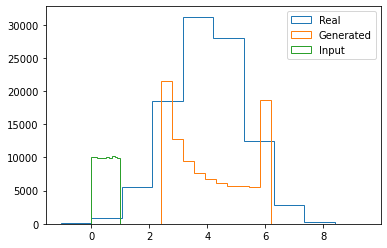

Stage 347 (Epoch: 34700)
Mean and Std of Real: (3.993866030637077, 1.2499827627382178)
Mean and Std of Gen: (4.21485, 1.1625966)


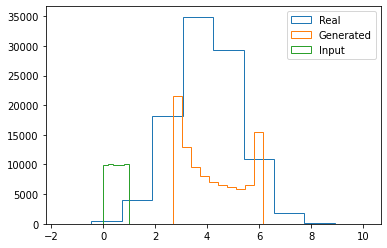

Stage 348 (Epoch: 34800)
Mean and Std of Real: (4.003620268869669, 1.2441776443505197)
Mean and Std of Gen: (4.039282, 1.3759348)


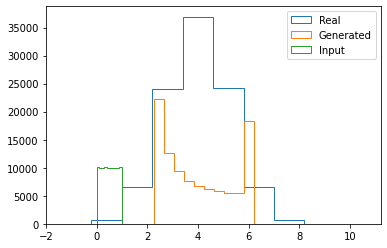

Stage 349 (Epoch: 34900)
Mean and Std of Real: (3.9943349293552584, 1.2471552862373518)
Mean and Std of Gen: (4.036836, 1.3754715)


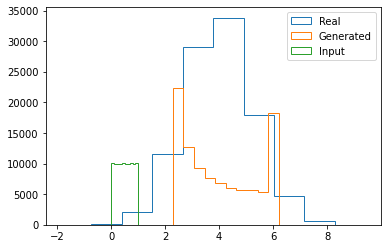

Stage 350 (Epoch: 35000)
Mean and Std of Real: (4.002200709924024, 1.249910406606209)
Mean and Std of Gen: (4.041669, 1.3759063)


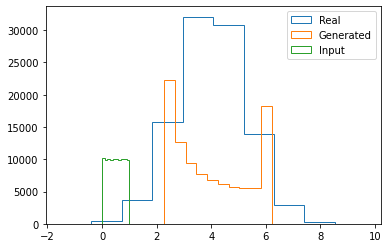

Stage 351 (Epoch: 35100)
Mean and Std of Real: (3.9988780504167365, 1.2494312853381047)
Mean and Std of Gen: (4.2234616, 1.2177374)


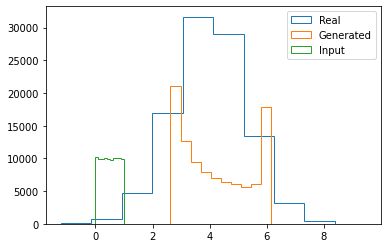

Stage 352 (Epoch: 35200)
Mean and Std of Real: (4.005096818579417, 1.2505073859738531)
Mean and Std of Gen: (4.226286, 1.2153137)


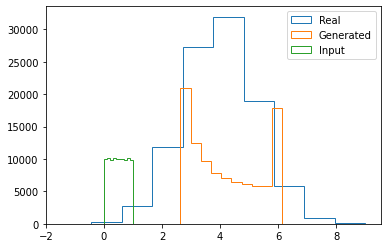

Stage 353 (Epoch: 35300)
Mean and Std of Real: (4.005556792454588, 1.2466885006496604)
Mean and Std of Gen: (4.225859, 1.2162939)


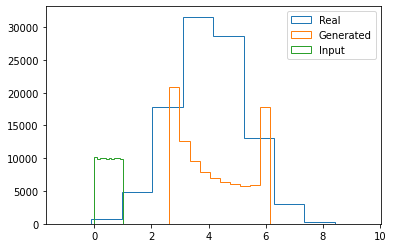

Stage 354 (Epoch: 35400)
Mean and Std of Real: (4.0005742344498865, 1.248237380781107)
Mean and Std of Gen: (4.221611, 1.214965)


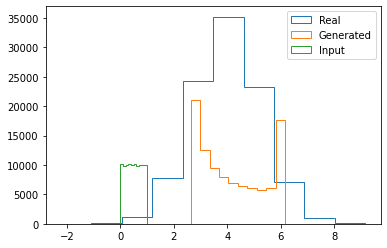

Stage 355 (Epoch: 35500)
Mean and Std of Real: (3.9951048491188397, 1.2502156917317304)
Mean and Std of Gen: (4.219337, 1.2162052)


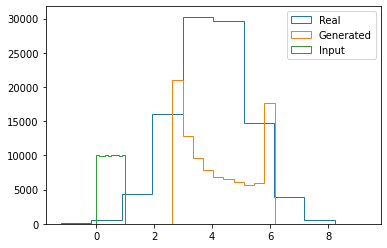

Stage 356 (Epoch: 35600)
Mean and Std of Real: (4.009432419174128, 1.249138719477908)
Mean and Std of Gen: (4.2257047, 1.2170718)


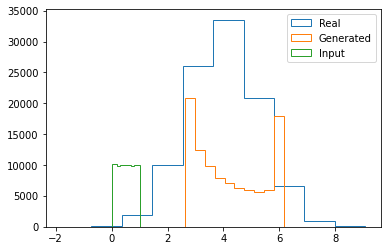

Stage 357 (Epoch: 35700)
Mean and Std of Real: (3.9971478416441655, 1.2478735109243848)
Mean and Std of Gen: (4.2213135, 1.215341)


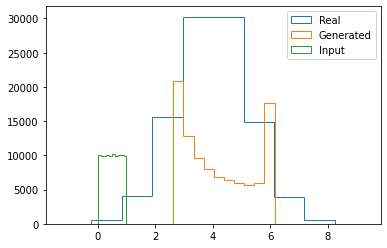

Stage 358 (Epoch: 35800)
Mean and Std of Real: (4.000798671298609, 1.2518973110496523)
Mean and Std of Gen: (4.2221804, 1.2160228)


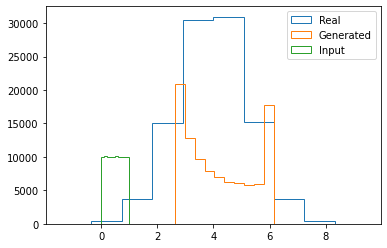

Stage 359 (Epoch: 35900)
Mean and Std of Real: (3.99730523880897, 1.2498139577146505)
Mean and Std of Gen: (4.2210283, 1.2135992)


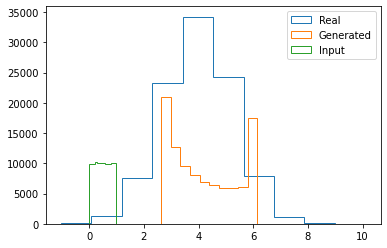

Stage 360 (Epoch: 36000)
Mean and Std of Real: (4.002333787325079, 1.2487332788603727)
Mean and Std of Gen: (4.2303, 1.2158403)


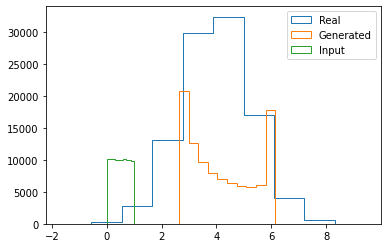

Stage 361 (Epoch: 36100)
Mean and Std of Real: (4.0004251459960996, 1.2506584950163615)
Mean and Std of Gen: (4.2205553, 1.2158327)


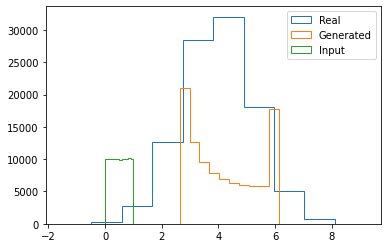

Stage 362 (Epoch: 36200)
Mean and Std of Real: (4.001847615286499, 1.2531930980842796)
Mean and Std of Gen: (4.2188497, 1.2172668)


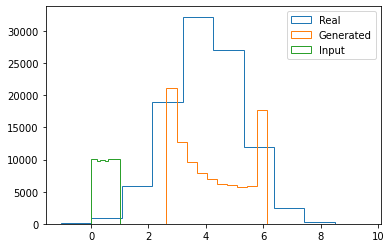

Stage 363 (Epoch: 36300)
Mean and Std of Real: (4.004908871218273, 1.2504280040360214)
Mean and Std of Gen: (4.2126217, 1.2135079)


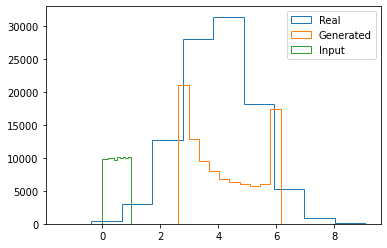

Stage 364 (Epoch: 36400)
Mean and Std of Real: (3.996872952940436, 1.249508775279828)
Mean and Std of Gen: (4.2195864, 1.2148399)


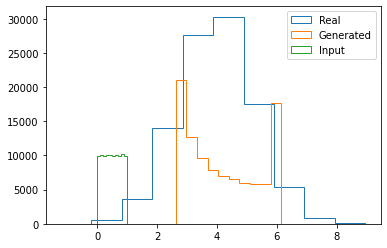

Stage 365 (Epoch: 36500)
Mean and Std of Real: (4.000310234017702, 1.250084218216516)
Mean and Std of Gen: (4.2260785, 1.2163317)


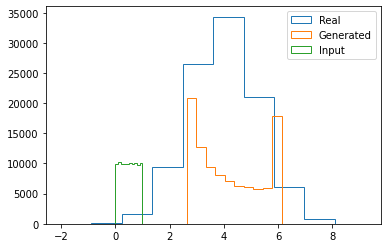

Stage 366 (Epoch: 36600)
Mean and Std of Real: (4.004849987965383, 1.252431121355439)
Mean and Std of Gen: (4.218901, 1.2140185)


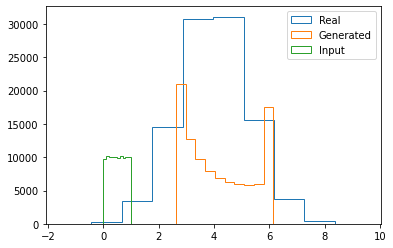

Stage 367 (Epoch: 36700)
Mean and Std of Real: (3.99752811133954, 1.2501978579198034)
Mean and Std of Gen: (4.2215466, 1.2163844)


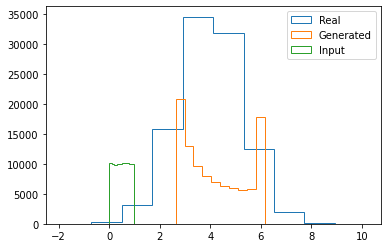

Stage 368 (Epoch: 36800)
Mean and Std of Real: (3.9982836113194935, 1.2495906498765865)
Mean and Std of Gen: (4.223069, 1.2125489)


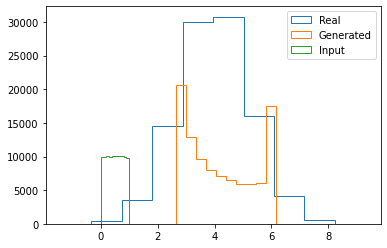

Stage 369 (Epoch: 36900)
Mean and Std of Real: (3.994301493309034, 1.2466649660634543)
Mean and Std of Gen: (4.220479, 1.2149936)


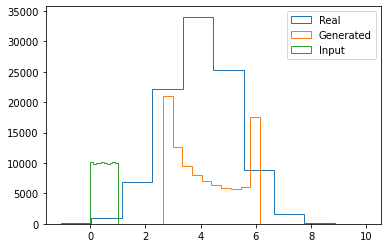

Stage 370 (Epoch: 37000)
Mean and Std of Real: (4.001094640905495, 1.2490097780078273)
Mean and Std of Gen: (4.2259183, 1.2148857)


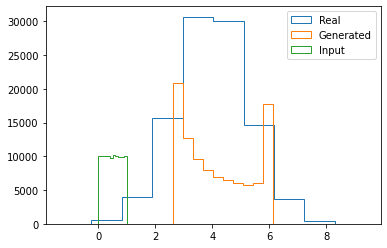

Stage 371 (Epoch: 37100)
Mean and Std of Real: (3.999808678575428, 1.247893869078993)
Mean and Std of Gen: (4.2273507, 1.2134948)


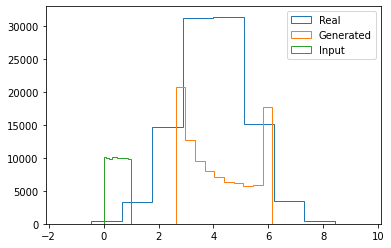

Stage 372 (Epoch: 37200)
Mean and Std of Real: (4.001702661850289, 1.2562208796372203)
Mean and Std of Gen: (4.2298775, 1.2159281)


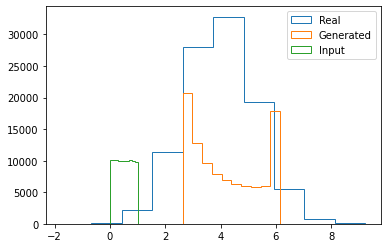

Stage 373 (Epoch: 37300)
Mean and Std of Real: (3.9968790694170537, 1.2505669060255582)
Mean and Std of Gen: (4.215721, 1.2148043)


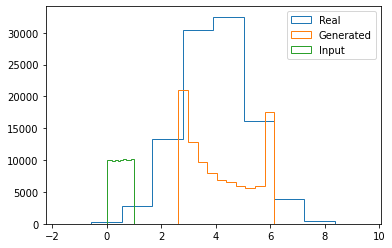

Stage 374 (Epoch: 37400)
Mean and Std of Real: (3.996372235467343, 1.2472165070945163)
Mean and Std of Gen: (4.2220273, 1.2142867)


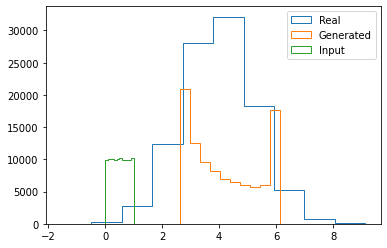

Stage 375 (Epoch: 37500)
Mean and Std of Real: (3.998787182001482, 1.2518493153251002)
Mean and Std of Gen: (4.2310143, 1.2171962)


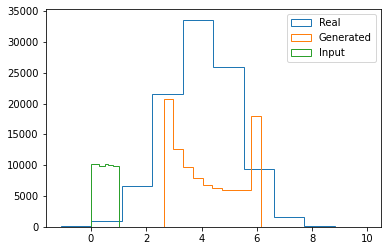

Stage 376 (Epoch: 37600)
Mean and Std of Real: (3.995537684675378, 1.2516103811318142)
Mean and Std of Gen: (4.227857, 1.2184787)


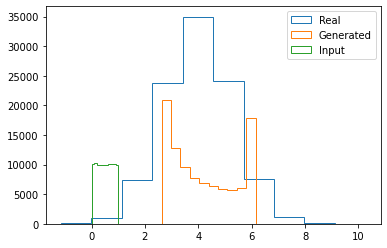

Stage 377 (Epoch: 37700)
Mean and Std of Real: (4.000609760208482, 1.2556358231884848)
Mean and Std of Gen: (4.224525, 1.2138889)


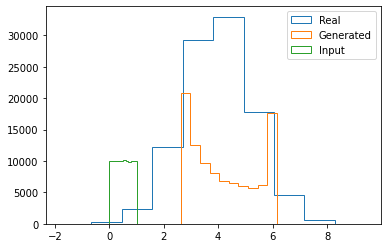

Stage 378 (Epoch: 37800)
Mean and Std of Real: (4.001122878001221, 1.2522149727164449)
Mean and Std of Gen: (4.219359, 1.2152709)


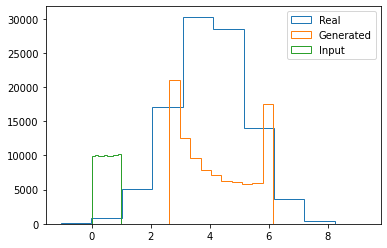

Stage 379 (Epoch: 37900)
Mean and Std of Real: (3.9979773129466087, 1.2499967993255736)
Mean and Std of Gen: (4.2141356, 1.2133391)


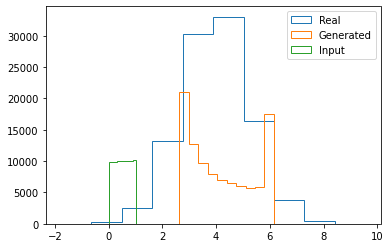

Stage 380 (Epoch: 38000)
Mean and Std of Real: (4.005434670092441, 1.2497515705942026)
Mean and Std of Gen: (4.2209425, 1.2167277)


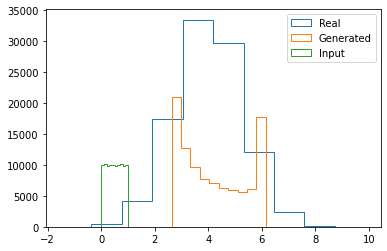

Stage 381 (Epoch: 38100)
Mean and Std of Real: (4.0040006737141765, 1.2517242453611164)
Mean and Std of Gen: (4.2200704, 1.2157192)


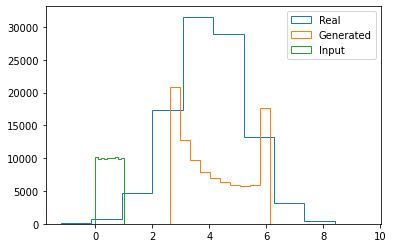

Stage 382 (Epoch: 38200)
Mean and Std of Real: (3.997837715393592, 1.2532232193605042)
Mean and Std of Gen: (4.2208223, 1.2148494)


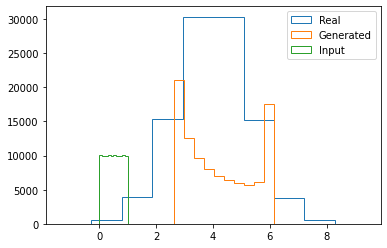

Stage 383 (Epoch: 38300)
Mean and Std of Real: (3.9914995596861886, 1.249127846674869)
Mean and Std of Gen: (4.221659, 1.2146963)


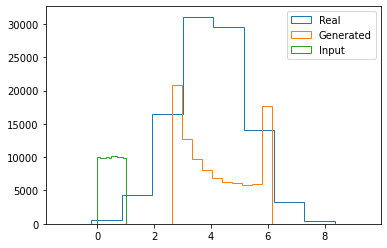

Stage 384 (Epoch: 38400)
Mean and Std of Real: (3.9961874540756916, 1.2470028308886336)
Mean and Std of Gen: (4.218337, 1.21574)


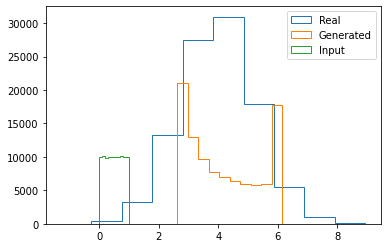

Stage 385 (Epoch: 38500)
Mean and Std of Real: (3.9929381302965594, 1.250280009693481)
Mean and Std of Gen: (4.2230883, 1.2131677)


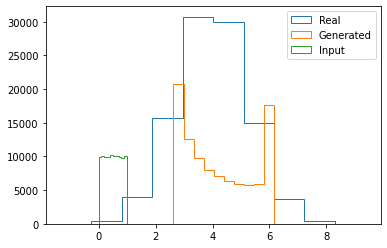

Stage 386 (Epoch: 38600)
Mean and Std of Real: (4.007670113740502, 1.251578900207839)
Mean and Std of Gen: (4.2258086, 1.2154758)


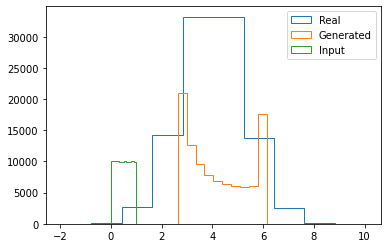

Stage 387 (Epoch: 38700)
Mean and Std of Real: (3.998195214529536, 1.2520141905327722)
Mean and Std of Gen: (4.222149, 1.215108)


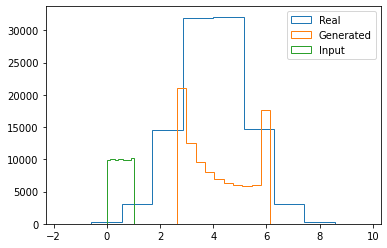

Stage 388 (Epoch: 38800)
Mean and Std of Real: (3.9938062739518037, 1.2489830931691284)
Mean and Std of Gen: (4.2188177, 1.2163109)


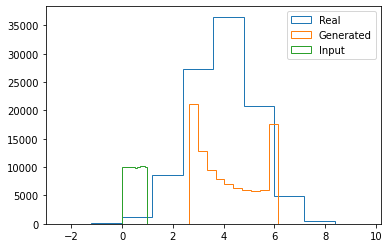

Stage 389 (Epoch: 38900)
Mean and Std of Real: (3.9981831520165967, 1.2497707621938214)
Mean and Std of Gen: (4.2254567, 1.2138091)


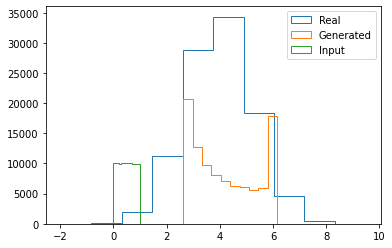

Stage 390 (Epoch: 39000)
Mean and Std of Real: (3.9965397475769975, 1.2493577975269903)
Mean and Std of Gen: (4.2216163, 1.2154187)


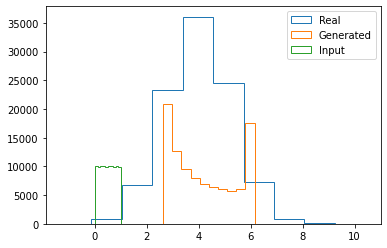

Stage 391 (Epoch: 39100)
Mean and Std of Real: (4.003418742589217, 1.2493564971118944)
Mean and Std of Gen: (4.2208743, 1.2148111)


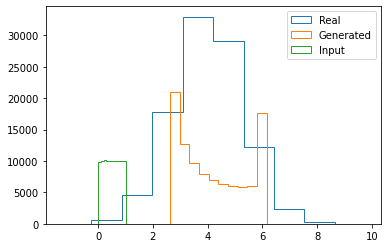

Stage 392 (Epoch: 39200)
Mean and Std of Real: (3.9989844195997755, 1.246457550646955)
Mean and Std of Gen: (4.224058, 1.2151299)


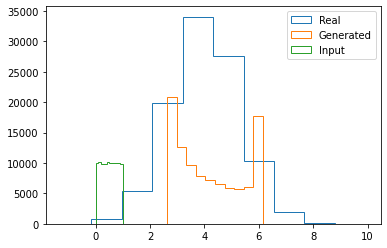

Stage 393 (Epoch: 39300)
Mean and Std of Real: (3.999343953069606, 1.2523569748114376)
Mean and Std of Gen: (4.22762, 1.2160636)


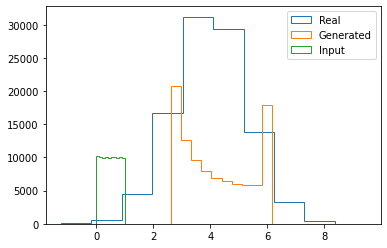

Stage 394 (Epoch: 39400)
Mean and Std of Real: (4.001709272233001, 1.254598711251114)
Mean and Std of Gen: (4.2190886, 1.2120271)


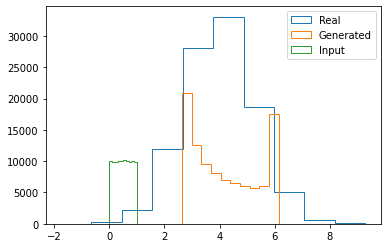

Stage 395 (Epoch: 39500)
Mean and Std of Real: (3.994163069251542, 1.2562645642009174)
Mean and Std of Gen: (4.2213287, 1.2136412)


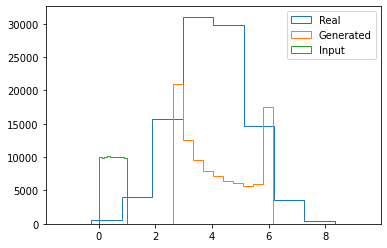

Stage 396 (Epoch: 39600)
Mean and Std of Real: (3.99606933814427, 1.2502736447993923)
Mean and Std of Gen: (4.216217, 1.213214)


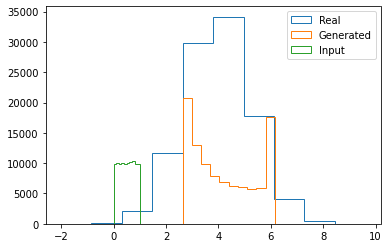

Stage 397 (Epoch: 39700)
Mean and Std of Real: (4.000406776757887, 1.2483886651245968)
Mean and Std of Gen: (4.220297, 1.2166501)


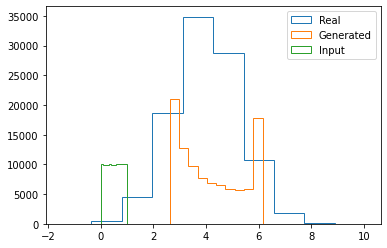

Stage 398 (Epoch: 39800)
Mean and Std of Real: (3.9996378816381744, 1.2458010418527266)
Mean and Std of Gen: (4.219547, 1.21574)


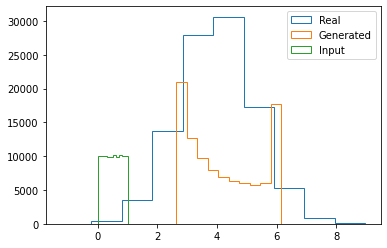

Stage 399 (Epoch: 39900)
Mean and Std of Real: (3.9974135978859024, 1.2478395159849158)
Mean and Std of Gen: (4.2214804, 1.2149513)


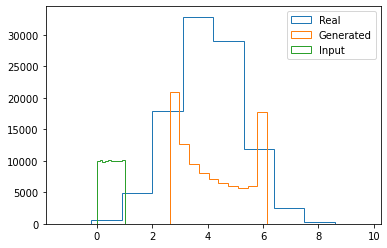

In [14]:
#import tensorflow.python.keras.backend as K
#sess = K.get_session()
#sess.run(tf.global_variables_initializer())
#keras.backend.get_session().run(tf.local_variables_initializer())
#keras.backend.get_session().run(tf.global_variables_initializer())
machine = Machine(n_batch=1, ni_D=1000)
machine.run(n_repeat=400, n_show=100, n_test=100)

In [6]:
import tensorflow as tf
tf.__version__

'1.15.2'

In [7]:
import tensorflow as tf
tf.__version__
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1660169161090267425
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 13775161659003328434
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 12618149536164005010
physical_device_desc: "device: XLA_GPU device"
]
